<h4><strong><center>Data Driven Trading:</center></strong></h4>
<h4><strong><center>Optimizing trade entry and exit using SAVGOL smoothing and ARIMA model.</center></strong></h4>

The main aim of this project was to employ data science techniques in forex trading, to identify high probability __trade entry__ and __trade exit__ points. To achieve this, two forex trading strategies, __ADX crossover__ strategy and __RSI divergence__ strategy will be optimized using an ARIMA (p,d,q) model, trained on a SAVGOL smoothed OHLC dataset. Python Backtesting will be used to determine trading strategies peformance. The results from both Optimized and unoptimized strategies will be compared and conclusions derived.  

__Note:__ csv copies of OHLC datasets used to generate the results published on the final report has been provided alongside this notebook. To simulate the results, the datasets should be uploaded in same location where this notebook will be running from. if the csv data is not uploaded, a 61-day , hourly data will be downloaded afresh from yahoofinance.

_The code is organized into eight sections highlighted below:_    
  --------------------------------------------------------------------
section(1): Import standard python libraries & initialize variables  
section(2): Helper finctions to be used accross the project  
section(3): Download OHLC data & data pre-processing   
section(4): Design ADX trading Strategy (Unoptimized)   
section(5): Train a Machine Learning Model - ARIMA       
section(6): Optimize ADX Trading strategy using ARIMA     
section(7): Design Divergence trading Strategy (Unoptimized)   
section(8): Optimize Divergence Trading strategy using ARIMA  

<h3><strong><center>Section (i): Libraries & Variables</center></strong></h3>

<h4><strong><left>Import standard python Libraries</left></strong></h4>

In [1]:
import os
import re
import math
import warnings
import numpy as np
import pandas as pd
import yfinance as yf
from time import sleep
import pandas_ta as ta
from itertools import *
from operator import setitem
import statsmodels.api as sm
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from backtesting import Strategy
from backtesting import Backtest
import plotly.graph_objects as go
from scipy.signal import find_peaks
from pandas.plotting import lag_plot
from scipy.signal import savgol_filter
from datetime import datetime,timedelta
from pmdarima.arima.utils import ndiffs
from plotly.subplots import make_subplots
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error,mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf,plot_predict

D:\projects\XY03222\venv\lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

<h4><strong><left>Initialize parameters and enviromental variables.</left></strong></h4>

In [2]:
#ignore future deprecation warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#disable pandas dataframe 'copy' warning as I am using copies of original dataframe for my usecase
pd.set_option('mode.chained_assignment', None)
#plotting params
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,10)
trading_pair =  'GBPUSD'
len_future_forecast = 2
train_test_split_ratio = 0.5
rsi_period = 14
#savgol parameters: window_size MUST be an odd number
svg_window_size = 21
svg_polyorder = 5
#distance is how close minimas can be, to maximas
peaks_distance = 15
peaks_width = 3
atr_window_size = 14
#ADX parameters
adx_threshold = 30
#yahooFinance parameters
timeframe = '1h'
yf_data_period = '61d'
#trading parameters
lot_size = 0.5

<h3><strong><center>Section (ii): Helper Functions</center></strong></h3>

In [3]:
###########################################
#This section has various helper functions
###########################################
def smoothing(df,svg_window_size, svg_polyorder):
    '''smoothing closing prices to reduce noise
    Inputs for function :
    1) time series data (closing price)
    2) window size for smoothing (has to be odd number)
    3) order of polynomial that will be used for partial data fits
    '''
    try:
        close_smooth = savgol_filter(df.close,svg_window_size, svg_polyorder,mode="nearest")
        msg = 'Smoothing done successfully'
        print(msg)
    except Exception as err:
        msg = f'{err} encountered while smoothing'
        print(msg)
    return close_smooth

def define_plotly_subplots(rows,cols,verticals_pacing,row_width):
    '''This Function will initialize the subplots by defining number of rows and 
    columns spacing between rows incase of multiple subplots'''
    try:
        #initialize figure
        fig = make_subplots(rows=rows, cols=cols,
                            shared_xaxes=True,
                            vertical_spacing=verticals_pacing,
                            row_width=row_width
                           )
        msg = f'a figure with ({rows}) subplots initialized successfully'
        print(msg)
    except Exception as err:
        msg = f'{err} encountered initalizing subplots'
        print(msg)
    return fig

def plot_ohlc_data(fig,df,row,col):
    '''This Function will plot OHLC data in form of candlesticks'''
    try:
        msg = 'plotting Raw OHLC data on Closing Price'
        print(msg)
        fig.add_trace(go.Candlestick(x=df.index,
                                 open=df.open, 
                                 high=df.high,
                                 low=df.low,
                                 close=df.close),row=row, col=col)
        msg = 'OHLC data plotted successfully'
        print(msg)
    except Exception as err:
        msg = f'{err} : encountered while plotting OHLC data'
        print(msg)
    return

def show_figure(fig):
    '''Display plotly plots and set layout to exclude weekends as market is closed'''
    try:
        fig.update(layout_xaxis_rangeslider_visible=False)

        #Hide Weekends and holidays when markets are closed.
        fig.update_xaxes(
            rangebreaks=[
                dict(bounds=["sat", "mon"]), #hide weekends
                dict(values=["2022-12-25", "2023-01-01"])  # hide Christmas and New Year's
            ])
        msg = 'figure rendered successfully'
        print(msg)
    except Exception as err:
        msg = f'{err} was encountered while showing figure'
        print(msg)
    return fig.show()

def label_axes(fig,xlabel,ylabel,title,row,col):
    '''This function will label x and y axis as well as title for the plot'''
    try:
        fig.update_yaxes(title_text=ylabel, row=row, col=col)
        msg = 'y-axes labelled successfully'
        print(msg)
        fig.update_xaxes(title_text=xlabel, row=row, col=col)
        msg = 'x-axes labelled successfully'
        print(msg)
        fig.update_layout(title_text=title, title_x=0.5)
        msg = 'Title labelled successfully'
        print(msg)
    except Exception as err:
        msg = f'{err} labelling axes'
        print(msg)
    return

def plot_df_column(fig,df,data_col,row,col,color,label):
    '''Function to plot line graph based on column name parsed'''
    try:
        fig.add_trace(go.Scatter(x=df.index, 
                                 y=df[f'{data_col}'],
                                 line=dict(color=color),
                                 name=label), row=row, col=col)
        msg = f'Plotting {data_col} successful'
        print(msg)
    except Exception as err:
        msg = f'{err} plotting {data_col}'
        print(msg)
    return

def Get_yf_OHLC_data(trading_pair,timeframe,period):
    '''
    Fetch historical OHLC data from Yahoo Finance for a specified, ticker, period and timeframe
    '''
    try:
        ohlc_data = yf.Ticker(f'{trading_pair}=X').history(period=f'{period}', interval=f'{timeframe}')
        msg = f'{len(ohlc_data)} : OHLC data points from yahoo finance for {timeframe} fetched successfully'
        print(msg)
    except Exception as err:
        msg = f'getting OHLC data from yahoo finance failed with error: {err}'
        print(msg)
    return ohlc_data

def generate_arima_summary(trading_pair,trade_type,lot_size,ohlc_test_data_ar,entry_exit_signals):
    '''
    This function will generate a tuple list with the summary of trades genertaed from ARIMA predicitions 
    '''
    try:
        for i in entry_exit_signals:
            trade_entry_signal = i[0]
            entry_time  = ohlc_test_data_ar.index[trade_entry_signal].strftime('%m-%d-%Y, %H:%M:%S')
            entry_price = ohlc_test_data_ar.iloc[trade_entry_signal].close_smooth
            # we now generate trade exit details based on prediction trend
            for predicted_trend in trend:
                #check for predictions after buy signal index
                if predicted_trend[0]>trade_entry_signal:
                    #if the trend is not an uptrend; we will exit at that point
                    if predicted_trend[2]!=1:
                        print(predicted_trend)
                        arima_exit_signal = predicted_trend[0]
                        arima_exit_time = ohlc_test_data_ar.index[arima_exit_signal].strftime('%m-%d-%Y, %H:%M:%S')
                        arima_exit_cls_price = round(predicted_trend[1],3)
                        #note that we will append the price from non-smoothed/original test set
                        #this will help is visualizing exit position more precisely and simulate real trading scenario
                        arima_exit_price.append((predicted_trend[0],ohlc_test_data_ar.iloc[predicted_trend[0]].close_smooth))
                        #trading_pair,trade_type,lot_size,entry_time,exit_time,entry_price,exit_price
                        trade_summary_tpl = tuple((trading_pair,trade_type,lot_size,entry_time,arima_exit_time,entry_price,arima_exit_cls_price))
                        trades_summary.append(trade_summary_tpl)
                        #validate if the suggested exit is more than 1 "prediction step" from entry signal
                        if int(predicted_trend[0])-int(trade_entry_signal)>1:
                            div_ar_entry_rows.append(trade_entry_signal)
                            div_ar_exit_rows.append(predicted_trend[0])
                        break
    except Exception as err:
        print(err)
    return trades_summary,div_ar_entry_rows,div_ar_exit_rows

def train_and_forecast(train_data,test_data,arima_order):
    '''
    This function will train an ARIMA model using training data set.The order of arima (p,d,q) is generated from auto_arima.
    The training data will be continously appended with test data (actual test value) on every loop, to ensure its updated
    and only forecasts the following/next datapoint only.
    Test data has been extended by n-forecast points, to produce both model test and by extension future forecast results.
    '''
    try:
        #initialize model predictions list
        model_predictions = []
        #number of test observations = test_data + number of future forecast data points
        test_observations = len(test_data)
        for i in range(test_observations):
            model = sm.tsa.arima.ARIMA(train_data,order = arima_order)
            #model_fit = model.fit()#default is 50 iterations
            model_fit = model.fit(method_kwargs={'maxiter':10000})#default is 50
            output = model_fit.forecast()
            predicted = output[0]
            if i==308:
                print(output)
                print(predicted)
            model_predictions.append(predicted)
            actual_test_value = test_data.iloc[i][0]
            if math.isnan(actual_test_value) :
                actual_test_value = predicted
                #print(actual_test_value,predicted)
            last_date = train_data.iloc[[-1]].index
            last_date = last_date + timedelta(hours=1)
            #print(last_date)
            data = {'close_smooth':actual_test_value} 
            #print(data)
            df_temp = pd.DataFrame(data, index=last_date)
            #print(df_temp)
            train_data = pd.concat([train_data,df_temp])
        msg = f'ARIMA Model of order {arima_order} trained successfully'
        msg = f'Forecast on extended test data completed successfully'
    except Exception as err:
        print(err)
    return model_fit,test_data,model_predictions

def arima_model_viz(model_predictions,test_data,len_future_forecast,trading_pair):
    '''
    function to visualize ARIMA models predictions and future forecast
    '''
    try:
        print('Visualizing Model prediction & Forecasting')
        len_actual_forecast = len_future_forecast-1
        plt.figure(figsize=(30,12))
        date_range = test_data.index
        plt.plot(date_range[:-len_future_forecast].astype(str),test_data[:-len_future_forecast],marker = 'o',color='red',label='Observed',linewidth=1)
        plt.plot(date_range[:-len_actual_forecast].astype(str),model_predictions[:-len_actual_forecast],color='green',marker = 'o',label='Predicted',linewidth=1)
        plt.plot(date_range[-len_future_forecast:].astype(str),model_predictions[-len_future_forecast:],marker = 'o',color='black',label='Forecast',linewidth=1)
        plt.title(f'ARIMA Forecast for {trading_pair} currency pair')
        plt.xlabel('Date & time', fontsize=10)
        plt.ylabel('Closing price', fontsize=10)
        plt.xticks(rotation=45)
        plt.legend()
        plt.show()
    except Exception as err:
        print(err)
    return

def get_prev_next_pred(lst):
    '''
    This function enables access to previous,current 
    and next item of a list in a for-loop
    '''
    try:
        prev, curr, nxt = tee(lst, 3)
        prev = chain([None], prev)
        nxt = chain(islice(nxt, 1, None), [None])
    except Exception as err:
        print(err)
    return zip(prev, curr, nxt)	

def rsi(df, periods,ema = True):
    """
    This functions computes relative strength index (RSI) on OHLC data closing price and returns a pandas series.
    """
    try:
        #generate closing price difference between current and previous value
        close_delta = df['close'].diff()

        # Make two series: one for lower closes and one for higher closes
        up = close_delta.clip(lower=0)
        down = -1 * close_delta.clip(upper=0)

        if ema == True:
            # Use exponential moving average
            msg = 'Using Exponential Moving average'
            print(msg)
            ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
            ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        else:
            # Use simple moving average
            msg = 'Using Simple Moving Average'
            print(msg)
            ma_up = up.rolling(window = periods, adjust=False).mean()
            ma_down = down.rolling(window = periods, adjust=False).mean()

        rsi = ma_up / ma_down
        rsi = 100 - (100/(1 + rsi))
        msg = 'RSI calculated successfully'
        print(msg)
    except Exception as err:
        msg = f'Error {err} encountered in RSI computation'
        print(msg)
    return rsi

def atr(df,atr_window_size):
    '''
    function to compute Average True Range on OHLC closing price using pandas technical analysis (ta) library.
    '''
    try:
        df['atr'] = ta.atr(high=df.high,low=df.low,close=df.close)
        df['atr'] = df.atr.rolling(window=atr_window_size).mean()
        msg = 'average true range (ATR) added successfully'
        print(msg)
    except Exception as err:
        msg = f'{err} encountered calculating ATR'
        print(msg)
    return(df)

def get_div_maxima_minima(data,distance,width):
    ''' 
    In this strategy, divergence signal is depicted by price moving from low to lower-low, 
    and RSI in increasing during the same period
    '''
    try:
        #generate maxima and minima indices
        atr = data.atr.iloc[-1]
        #distance and width is how close maxima and minima can be close to each other.
        peaks_idx = find_peaks(data.close_smooth,distance=distance,width=width,prominence=atr)
        #print(peaks_idx[0])
        peaks_idx = peaks_idx[0]
        #we multiply closed_smooth price with (-1) to make the troughs peaks and peaks troughs, 
        #then find the peaks which are essentially representing troughs
        troughs_idx = find_peaks(-1*data.close_smooth,distance=15,width=3,prominence=atr)
        #print(troughs_idx[0])
        troughs_idx = troughs_idx[0]
        #label the lists as high and low and append closing prices on highs and lows
        highs_list= [(i,data.close_smooth.iloc[i],'H') for i in peaks_idx]
        lows_list = [(i,data.close_smooth.iloc[i],'L') for i in troughs_idx]
        #combine the lists to get one unified list
        comb_list = highs_list+lows_list
        #sort the combined lists
        comb_list = sorted(
            comb_list, 
            key=lambda x: x[0]
        )
        lower_low_indx = []
        #loop through the combined list and identify the lower-lows
        for i,j in enumerate(comb_list):
            #skip the first row since it doesnt have a previous entry
            if i>0:
                #current is (Low),previous was a (High) and before that we had a (Low) and 
                #current low is lower and previous low then, that a lower-low
                if j[2]=='L' and comb_list[i-1][2]=='H' and comb_list[i-2][2]=='L' and j[1]<comb_list[i-2][1]:
                    #print(f'{j} is a lower-low')
                    #validate that the index is not negative
                    if i-2>=0:
                        lower_low_indx.append((comb_list[i-2][0],j[0]))
        #print('indices for low->lower-lows points')
        #print(lower_low_indx)
        msg = 'Maxima and Minima generated successfully'
        print(msg)
    except Exception as err:
        msg = f'{err} encountered generating divergence maxima and minima'
        print(msg)
    return data,lower_low_indx,peaks_idx,troughs_idx,comb_list

def generate_div_entry_signals(df,lower_low_indx):
    '''This function generates divergence strategy entry signals'''
    try:
        #Initialize divergence points count
        cnt = 0
        #list for indices for entry signals
        entry_signal_index = []
        #initialize divergence Signal
        df['divergence_signal'] = 0 
        #intialize trade entry list
        div_entry_rows = []
        for i in lower_low_indx:
            print(i)
            #Closing prices representing lows and lowerlows
            low_cls_price = df.close_smooth.iloc[i[0]]
            lower_low_cls_price = df.close_smooth.iloc[i[1]]
            #RSI at starting point and end point at same position of chart closing price
            rsi_cls_start = df.rsi.iloc[i[0]]
            rsi_cls_end = df.rsi.iloc[i[1]]
            #Identify trading signal where closing price is going down while rsi is increasing
            if lower_low_cls_price<low_cls_price and rsi_cls_end>rsi_cls_start :
                print(df.index[i[1]])
                print(i[1])
                entry_signal_index.append(df.index[i[1]])
                cnt+=1
                div_entry_rows.append(i[1])
                print('Divergence point identified')
                try:
                    #Mark signal as 2 for BUY
                    df.divergence_signal.iloc[i[1]]=2
                except RuntimeWarning:
                    pass
        msg = (f'{cnt} Divergence points selected successfully')
        print(msg)
    except Exception as err:
        msg = 'Error was encountered deriving divergence Entry points'
        print(msg)
        print(err)
    return(df,cnt,entry_signal_index,div_entry_rows)

def plot_lows_highs(fig,df,peaks_idx,troughs_idx,row,col,marker_color):
    '''
    Using plotly to plot visualize peaks(highs) and troughs(lows) based on input list of indices
    '''
    try:
        #fig.add_trace(go.Scatter(x=df.index[peaks_idx], y=df.close_smooth.iloc[peaks_idx], mode="markers",
        #                         marker=dict(symbol='star',color='magenta',size=10),
        #                         name="highs"), row=row, col=col)

        #Plot minima(lows)
        fig.add_trace(go.Scatter(x=df.index[troughs_idx], y=df.close_smooth.iloc[troughs_idx], mode="markers",
                                 marker=dict(symbol='star',color=marker_color,size=10),
                                 name="Lows"), row=row, col=col)
        msg = 'plotting low_highs successful'
        print(msg)
    except Exception as err:
        msg = f'plotting low_highs failed with error {err}'
        print(msg)
    return

def plot_low_lower_lows(fig,df,lower_low_indx,row,col,color):
    '''
    visualize the line between the low and lower-lows based on smoothed closing balances
    '''
    try:
        line_color=dict(color=color)
        for i in lower_low_indx:
            start_point = df.close_smooth.iloc[i[0]]
            end_point = df.close_smooth.iloc[i[1]]
            fig.add_trace(go.Scatter(x=[df.index[i[0]],df.index[i[1]]],
                     y=[start_point,end_point],
                      line=line_color), row=row, col=col)      
        msg = 'Plotting low to lower-lows successful'
        print(msg)
    except Exception as err:
        msg = f'{err} plotting low to lower-lows'
        print(msg)
    return

def plot_rsi(fig,df,row,col,color):
    '''
    function to visualize RSI using plotly
    '''
    try:
        fig.add_trace(go.Scatter(x=df.index, 
                                 y=df.rsi,
                                 line=dict(color=color),
                                 name='RSI'), row=row, col=col)
        msg = 'Plotting RSI successful'
        print(msg)
    except Exception as err:
        msg = f'{err} plotting RSI'
        print(msg)
    return

def lower_low_on_rsi(fig,df,lower_low_indx,row,col,color):
    '''
    Visualize a line showing RSI movement as the prices move from low to lower low
    '''
    try:
        #visualize same points on the RSI plot
        for i in lower_low_indx:
            start_point = df.rsi.iloc[i[0]]
            end_point = df.rsi.iloc[i[1]]
            #define plotting colors
            if float(end_point)>float(start_point):
                line_color=dict(color='green')
            else:
                line_color=dict(color=color)
            fig.add_trace(go.Scatter(x=[df.index[i[0]],df.index[i[1]]],
                     y=[start_point,end_point],
                      line=line_color), row=row, col=col)
        msg = 'plotting lower-lows against RSI was successful'
        print(msg)
    except Exception as err:
        msg = f'{err} plotting low to lows against RSI'
        print(msg)
    return

def fig_layout(fig,width,height):
    '''
    add plotly layout
    '''
    try:
        #layout parameters
        fig.update_layout(
        autosize=False,
        width=width,
        height=height)
        fig.update_xaxes(tickmode='linear')
        #Hide the rangeslider graph
        fig.update(layout_xaxis_rangeslider_visible=False)
        
        msg = f'layout set successfully'
        print(msg)
    except Exception as err:
        msg = f'{err} setting fig layout'
        print(msg)
    return

def divergence_strategy_exit(ohlc_test_data,trading_pair,trade_type,lot_size,entry_exit_signals):
    '''
    we will use EMA50 to exit after a divergence is observed. 
    Once the closing price crosses EMA50, we will exit the trade
    This function will handle BUY only
    '''
    try:
        for i in entry_exit_signals:
            entry_price = ohlc_test_data.iloc[i[0]].close
            entry_time = ohlc_test_data.index[i[0]].strftime("%m-%d-%Y, %H:%M:%S")
            exit_price = ohlc_test_data.iloc[i[1]].close
            #append trade exit index and closing price
            div_exit_cls_price.append((i[1],exit_price))
            exit_time = ohlc_test_data.index[i[1]].strftime("%m-%d-%Y, %H:%M:%S")
            trade_summary_tpl = tuple((trading_pair,trade_type,lot_size,entry_time,exit_time,entry_price,exit_price))
            trades_summary.append(trade_summary_tpl)
    except Exception as err:
        print(err)
    return trades_summary,div_exit_cls_price

def fn_train_test_split(data_close,split_ratio):
    '''
    split OHLC data into test and training datasets based on the input split ratio.
    '''
    try:
        #train-test split
        train_test_split = int(len(data_close)*split_ratio)
        train_data = data_close[:train_test_split]
        test_data = data_close[train_test_split:]
    except Exception as err:
        print(err)
    return train_data,test_data,train_test_split

def compute_adx(high, low, close, lookback):
    '''
    This function computes average directional indicator (ADX) using ATR. 
    '''
    #calculate the positve DM(pdm) as CURRENT HIGH - PREVIOUS HIGH
    pdm = high.diff()
    #calculate the negative DM (ndm) as - DM = PREVIOUS LOW - CURRENT LOW
    ndm = low.diff()
    #zerorise where positive DM is less than 0 or negative DM is greater than zero.
    pdm[pdm < 0] = 0
    ndm[ndm > 0] = 0
    
    #to compute the ATR as MAX [ {HIGH - LOW}, {HIGH - Prev.CLOSE}, {Prev.CLOSE - LOW} ]
    var0 = pd.DataFrame(high - low)
    var1 = pd.DataFrame(abs(high - close.shift(1)))
    var2 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [var0, var1, var2]
    #Get MAX of the three variables
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    #compute the ATR
    atr = tr.rolling(lookback).mean()
    
    pdi = 100 * (pdm.ewm(alpha = 1/lookback).mean() / atr)
    ndi = abs(100 * (ndm.ewm(alpha = 1/lookback).mean() / atr))
    dx = (abs(pdi - ndi) / abs(pdi + ndi)) * 100
    adx = ((dx.shift(1) * (lookback - 1)) + dx) / lookback
    adx_smooth = adx.ewm(alpha = 1/lookback).mean()
    return pdi, ndi, adx_smooth

def adx_strategy_entry(closing_price, pdi, ndi, adx,adx_threshold):
    '''
    This function will append buy and sell signals for ADX strategy
    '''
    #initialize parameters and lists
    buying_price = []
    selling_price = []
    buying_indices = []
    selling_indices = []
    adx_signal = []
    signal = 0
    
    #looping through closing prices 
    for i in range(len(closing_price)):
        #for an uptrend;adx has crossed the threshold line and +DI > -DI
        if ((adx[i-1] < adx_threshold and adx[i] > adx_threshold) and pdi[i] > ndi[i] and i>0):
            if signal != 1:
                #set the buying price
                buying_price.append(closing_price[i])
                buying_indices.append(i)
                selling_price.append(np.nan)
                #update buy signal
                signal = 1
                adx_signal.append(signal)
                #reset the signal
                signal = 0
            else:
                buying_price.append(np.nan)
                selling_price.append(np.nan)
                adx_signal.append(0)
                
        #for a downtrend ;adx has crossed the threshold line and +DI < -DI
        elif ((adx[i-1] < adx_threshold and adx[i] > adx_threshold) and ndi[i] > pdi[i] and i>0):
            if signal != -1:
                buying_price.append(np.nan)
                selling_price.append(closing_price[i])
                selling_indices.append(i)
                #update sell signal
                signal = -1
                adx_signal.append(signal)
                #reset the signal
                signal = 0
            else:
                buying_price.append(np.nan)
                selling_price.append(np.nan)
                adx_signal.append(0)
        else:
            buying_price.append(np.nan)
            selling_price.append(np.nan)
            adx_signal.append(0)
            
    return buying_price, selling_price, adx_signal,buying_indices,selling_indices

def adx_strategy_exit(ohlc_data,trading_pair,lot_size,buying_price,selling_price,plus_di,minus_di):
    '''
    this function will derive the trade exit for buy position. 
    a buy position is based on "cross" where negative directional indicatorv (-DI) crosses the positive directional 
    indicator (+DI). 
    '''
    #initialize parameters
    trades_summary = []
    buy_index=-1
    newpos=0
    trade_type = 'B'
    #loop through buying list, +DI and -DI lists
    for i,j,k in zip(enumerate(buying_price),plus_di,minus_di):
        #check if the buying list has a buy position 
        if not(np.isnan(i[1])):
            print('buy position; Trade Entry found')
            buy_index = i[0]
            #print(buy_index)
            #update new position placeholder
            newpos=1
            #get the closing price which is the trade entry price
            entry_price = ohlc_data.close.iloc[i[0]]
            print(entry_price)
            entry_time=ohlc_data.index[i[0]].strftime("%m-%d-%Y, %H:%M:%S")
        #look out for the next cross for the new position where +DI=-DI
        if round(j,0)==round(k,0) and newpos==1:
            #validate that the new index is greater than the index for buy position 
            if i[0]>buy_index and buy_index>-1:
                #reset the new position placeholder 
                newpos=0
                print('cross found ;Trade Exit position')
                #get the exit price for the corresponding trade entry
                exit_price = ohlc_data.close.iloc[i[0]]
                print(exit_price)
                exit_time=ohlc_data.index[i[0]].strftime("%m-%d-%Y, %H:%M:%S")
                #create a trade summary tuple, to be used for backtesting
                trade_summary_tpl = tuple((trading_pair,trade_type,lot_size,entry_time,exit_time,entry_price,exit_price))
                trades_summary.append(trade_summary_tpl)
                
    #derive the trade exit for sell position. this is based on cross where -DI crosses +DI
    #initialize parameters
    sell_index=-1
    newpos=0
    trade_type = 'S'
    #loop through buying list, +DI and -DI lists
    for i,j,k in zip(enumerate(selling_price),plus_di,minus_di):
        #check if the buying list has a buy position 
        if not(np.isnan(i[1])):
            print('Sell entry position; Trade Entry found')
            sell_index = i[0]
            #print(buy_index)
            #update new position placeholder
            newpos=1
            #get the closing price which is the trade entry price
            entry_price = ohlc_data.close.iloc[i[0]]
            print(entry_price)
            entry_time=ohlc_data.index[i[0]].strftime("%m-%d-%Y, %H:%M:%S")
        #look out for the next cross for the new position where +DI=-DI
        if round(j,0)==round(k,0) and newpos==1:
            #validate that the new index is greater than the index for buy position 
            if i[0]>sell_index and sell_index>-1:
                #reset the new position placeholder 
                newpos=0
                print('cross found ;Sell Exit position')
                #get the exit price for the corresponding trade entry
                exit_price = ohlc_data.close.iloc[i[0]]
                print(exit_price)
                exit_time=ohlc_data.index[i[0]].strftime("%m-%d-%Y, %H:%M:%S")
                trade_summary_tpl = tuple((trading_pair,trade_type,lot_size,entry_time,exit_time,entry_price,exit_price))
                trades_summary.append(trade_summary_tpl)
    return trades_summary
    
def gen_trade_exit_points(ohlc_data,trades_summary):
    #generate trade-exit points (exit price) and append them on a on list
    trade_exit_points = []
    #generate trade-exit indices (numeric) and append them on a on list
    trade_exit_indices = []
    for e,(idx,j) in enumerate(ohlc_data.iterrows()):
        exit_price=np.nan
        #match trade-exit timestamp with dataframe index and append exit price on the list
        for i in trades_summary:
            if idx.replace(tzinfo=None)== datetime.strptime(i[4],"%m-%d-%Y, %H:%M:%S"):
                exit_price = i[6]
                trade_exit_indices.append(e)
        trade_exit_points.append(exit_price)
    return trade_exit_points,trade_exit_indices

def generate_order_of_arima(df):
    '''
    This function will derive the order of arima (p,d,q) using auto-arima module using adf test.
    '''
    try:
        #to generate p,d,q values, we will use auto_arima
        auto_model = auto_arima(df.close_smooth, start_P=1, start_Q=1,
                              test='adf',       # use adftest to find optimal 'd'
                              m=1,              # frequency of series
                              d=None,           # let model determine 'd'
                              seasonal=False,   # No Seasonality
                              trace=True,
                              stepwise=True)
        Order = auto_model.order
        msg = f'ARIMA order {Order} generated successfully'
        print(msg)
    except Exception as err:
        msg = 'Error encountered generating ARIMA order'
        print(err)
    return Order

def add_freq_df_index(df,period):
    '''
    This generic function will add period frequency to timeseries data (time based index)
    '''
    try:
        df.index = pd.DatetimeIndex(df.index).to_period(f'{period}')
    except Exception as err:
        print(err)
    return

def add_forecast_parms(len_future_forecast,test_data):
    '''
    function to append n future forecast period to test data.
    '''
    try:
        #extract the last index on full dataset to start forecast
        start_forecast  = test_data.tail(1).index.item()
        print(f'forecast starts at {start_forecast} for length period of: {len_future_forecast-1}')
        future_dates=[test_data.index[-1] + timedelta(hours=i) for i in range(0,len_future_forecast)]
        future_datest_df=pd.DataFrame(index=future_dates[1:],columns=test_data.columns)
        future_datest_df.tail()
        test_data=pd.concat([test_data,future_datest_df])
        msg = f'{len_future_forecast-1} forecast period appended/extended on test data'
        print(msg)
    except Exception as err:
        print(err)
    return test_data,future_dates
       
def ARIMA_peformance(test_data,model_predictions,len_future_forecast):
    '''
    This function return peformance of an ARIMA model, based on MAPE,RSME and MAE peformance metrics
    '''
    try:
        print('Model Performance Metrics')
        print('*************************')
        #ensure there are no NAN prediction prior to error computation
        for i,(o,p) in enumerate(zip(ohlc_test_data_ar.iterrows(),model_predictions)):
            if np.isnan(p):
                ohlc_test_data_ar.drop(ohlc_test_data_ar.iloc[i].name,  inplace=True)
                model_predictions.pop(i)
        #compute the errors.
        #(1) MAPE
        #we calculate MAPE leaving out future forecast values as we want to assess accuracy on test data only
        mape = np.mean(np.abs(np.array(test_data[:-len_future_forecast].close_smooth)-np.array(model_predictions[:-len_future_forecast]))/np.abs(test_data[:-len_future_forecast].close_smooth))
        # Print the MAPE value and percentage
        print(f'MAPE   : { round(mape, 5) }')
        print(f'MAPE % : { round(mape*100, 5) } %')
        print('*************************')
        #(2) RMSE
        #calculate the RMSE excluding future forecast values
        rmse = math.sqrt(mean_squared_error(test_data[:-len_future_forecast].close_smooth,model_predictions[:-len_future_forecast]))
        print(f'RMSE: {round(rmse,5)}')
        #print(f'RMSPE percent: {round(rmse,5)*100}%')
        print('**************************************')
        #(3) MAE
        y_true, predictions = np.array(test_data[:-len_future_forecast].close_smooth), np.array(model_predictions[:-len_future_forecast])
        mae = np.mean(np.abs(y_true - predictions))
        print(f'Mean Absolute Error (MAE) is : {round(mae,5)}')
        print('**************************************')
    except Exception as err:
        print(err)
    return 

def check_stationarity(df,col):
    ''' 
    This function to check stationality of data.
    Input parameters are dataframe and column to check/test stationarity
    '''
    df = df.dropna()
    result = adfuller(df[col].values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print()
    #if P-value is less than 0.05 data is stationary else Not.
    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("The Data is stationary")
    else:
        print("The data is Non-stationary")
##############################
#Backtesting helper functions
##############################
#unoptimized adx strategy

#function to fetch trade entry signals for unoptimized adx trading strategy
def adx_entry_signal():
    return ohlc_bt_data.adx_buysell_signal

#function to fetch trade exit signals for unoptimized adx trading strategy
def adx_trade_exit_signal():
    return ohlc_bt_data.adx_exit_signal

#Trading strategy class for unoptimized adx trading strategy
class unoptimized_adx_strategy(Strategy):
    #initialize forex trading lotsize
    initsize = 0.5
    mysize = initsize
    def init(self):
        #initialize and call trade entry and exit functions
        super().init()
        self.signal1 = self.I(adx_entry_signal)
        self.signal2 = self.I(adx_trade_exit_signal)

    def next(self):
        super().next()
        #fetching buy signals. we will run one trade at a time
        if self.signal1==2 and len(self.trades)==0:
            #setting stop loss and take profit risk parameters at 100pips for buy trades
            sl1 = self.data.Close[-1] - 200e-4
            tp1 = self.data.Close[-1] + 200e-4
            self.buy(sl=sl1, tp=tp1, size=self.mysize)
            #self.buy()
        #fetching sell signals. we will run one trade at a time
        elif self.signal1==1 and len(self.trades)==0:  
            #setting stop loss and take profit risk parameters at 100pips for buy trades
            sl1 = self.data.Close[-1] + 200e-4
            tp1 = self.data.Close[-1] - 200e-4
            self.sell(sl=sl1, tp=tp1, size=self.mysize)
            #self.sell()
        #close trading position when an exit signal is detected
        if self.signal2 == 1:
            self.position.close()

#Optimized adx strategy
#function to fetch trade entry signals for optimized adx trading strategy
def adx_ar_entry_signal():
    return ohlc_bt_data.adx_ar_buysell_signal

#function to fetch trade exit signals for optimized adx trading strategy
def adx_ar_exit_signal():
    return ohlc_bt_data.adx_ar_exit_signal

#Trading strategy class for optimized adx trading strategy
class optimized_adx_strategy(Strategy):
    #initialize forex trading lotsize
    initsize = 0.5
    mysize = initsize
    def init(self):
        #initialize and call trade entry and exit functions
        super().init()
        self.signal1 = self.I(adx_ar_entry_signal)
        self.signal2 = self.I(adx_ar_exit_signal)

    def next(self):
        super().next()
        #fetching buy signals. we will run one trade at a time
        if self.signal1==2 and len(self.trades)==0:
            #setting stop loss and take profit risk parameters at 100pips
            sl1 = self.data.Close[-1] - 200e-4
            tp1 = self.data.Close[-1] + 200e-4
            self.buy(sl=sl1, tp=tp1, size=self.mysize)
            #self.buy()
        #fetching sell signals. we will run one trade at a time
        elif self.signal1==1 and len(self.trades)==0:
            #setting stop loss and take profit risk parameters at 100pips
            sl1 = self.data.Close[-1] + 200e-4
            tp1 = self.data.Close[-1] - 200e-4
            self.sell(sl=sl1, tp=tp1, size=self.mysize)
            #self.sell()
        #close trading position when an exit signal is detected
        if self.signal2 == 1:
            self.position.close()

#Unoptimized Divergence Strategy
#function to fetch trade entry signals for unoptimized divergence trading strategy
def div_entry_signal():
    return ohlc_bt_data.div_buysell_signal

#function to fetch trade exit signals for unoptimized divergence trading strategy
def div_trade_exit_signal():
    return ohlc_bt_data.div_exit_signal

#Trading strategy class for unoptimized divergence trading strategy
class unoptimized_div_strategy(Strategy):
    #initialize forex trading lotsize
    initsize = 0.5
    mysize = initsize
    def init(self):
        #initialize and call trade entry and exit functions
        super().init()
        self.signal1 = self.I(div_entry_signal)
        self.signal2 = self.I(div_trade_exit_signal)

    def next(self):
        super().next()
        #fetching buy signals. we will run one trade at a time
        if self.signal1==2 and len(self.trades)==0:
            #setting stop loss and take profit risk parameters at 100pips
            sl1 = self.data.Close[-1] - 200e-4
            tp1 = self.data.Close[-1] + 200e-4
            self.buy(sl=sl1, tp=tp1, size=self.mysize)
            #self.buy()
        #fetching sell signals. we will run one trade at a time
        elif self.signal1==1 and len(self.trades)==0:
            #setting stop loss and take profit risk parameters at 100pips
            sl1 = self.data.Close[-1] + 200e-4
            tp1 = self.data.Close[-1] - 200e-4
            self.sell(sl=sl1, tp=tp1, size=self.mysize)
            #self.sell()
        #close trading position when an exit signal is detected
        if self.signal2 == 1:
            self.position.close()

#Optimized Divergence strategy
#function to fetch trade entry signals for optimized divergence strategy
def div_ar_entry_signal():
    return ohlc_bt_data.div_ar_buysell_signal
    
#function to fetch trade exit signals for optimized divergence strategy
def div_ar_exit_signal():
    return ohlc_bt_data.div_ar_exit_signal

#Trading strategy class for optimized divergence strategy
class optimized_div_strategy(Strategy):
    #initialize trading lotsize
    initsize = 0.5
    mysize = initsize
    def init(self):
        #initialize and call trade entry and exit functions
        super().init()
        self.signal1 = self.I(div_ar_entry_signal)
        self.signal2 = self.I(div_ar_exit_signal)

    def next(self):
        super().next()
        #fetching buy signals. we will run one trade at a time
        if self.signal1==2 and len(self.trades)==0:
            #setting stop loss and take profit risk parameters at 100pips
            sl1 = self.data.Close[-1] - 200e-4
            tp1 = self.data.Close[-1] + 200e-4
            self.buy(sl=sl1, tp=tp1, size=self.mysize)
            #self.buy()
        #fetching sell signals. we will run one trade at a time
        elif self.signal1==1 and len(self.trades)==0:
            #setting stop loss and take profit risk parameters at 100pips
            sl1 = self.data.Close[-1] + 200e-4
            tp1 = self.data.Close[-1] - 200e-4
            self.sell(sl=sl1, tp=tp1, size=self.mysize)
            #self.sell()
        #close trading position when an exit signal is detected
        if self.signal2 == 1:
            self.position.close()
           

<h3><strong><center>Section(iii): Data Collection and Data pre-processing</center></strong></h3>

<h4><strong><left>Dataset.</left></strong></h4>

In [4]:
try:
    #initialize file_name
    file_name = f'ohlc_data_{trading_pair}.csv'
    #check if file is already saved; if not download data from yahoo finance
    isExist = os.path.isfile(file_name)
    if isExist:
        try:
            print(f'data file for {trading_pair} already saved')
            ohlc_data = pd.read_csv(file_name)
            msg = f'{len(ohlc_data)} records for {trading_pair} uploaded successfully from a local copy.'
            print(msg)
            ohlc_data['Datetime'] = pd.to_datetime(ohlc_data['Datetime'])
            ohlc_data = ohlc_data.set_index('Datetime')
        except Exception as err:
            print(err)
    else:
        print(f'data file for {trading_pair} not saved..downloading from yahoofinance')
        #download data for a trading currency pair
        ohlc_data = Get_yf_OHLC_data(trading_pair,timeframe,yf_data_period)
        if len(ohlc_data)!=0:
            msg = f'{len(ohlc_data)} records for {trading_pair} downloaded successfully'
            print(msg)
            # saving the dataframe
            print(file_name)
            #drop timezone
            ohlc_data.index = ohlc_data.index.tz_localize(None)
            ohlc_data.to_csv(file_name)
           
        else:
            raise Exception(f"No records fetched for {trading_pair}!")
except Exception as err:
    msg = f'Fetching data for {trading_pair} failed with error: {err}'
    print(msg)

data file for GBPUSD already saved
1183 records for GBPUSD uploaded successfully from a local copy.


In [5]:
ohlc_data.head()

Open      High       Low     Close  Volume  \
Datetime                                                                    
2023-06-26 00:00:00+01:00  1.272313  1.273172  1.272168  1.272961       0   
2023-06-26 01:00:00+01:00  1.273285  1.273610  1.272588  1.273301       0   
2023-06-26 02:00:00+01:00  1.273431  1.273853  1.272831  1.273139       0   
2023-06-26 03:00:00+01:00  1.273123  1.273723  1.273123  1.273334       0   
2023-06-26 04:00:00+01:00  1.273301  1.273610  1.273026  1.273220       0   

                           Dividends  Stock Splits  
Datetime                                            
2023-06-26 00:00:00+01:00        0.0           0.0  
2023-06-26 01:00:00+01:00        0.0           0.0  
2023-06-26 02:00:00+01:00        0.0           0.0  
2023-06-26 03:00:00+01:00        0.0           0.0  
2023-06-26 04:00:00+01:00        0.0           0.0

In [6]:
ohlc_data.describe()

Open         High          Low        Close  Volume  Dividends  \
count  1183.000000  1183.000000  1183.000000  1183.000000  1183.0     1183.0   
mean      1.277893     1.278672     1.277122     1.277886     0.0        0.0   
std       0.012898     0.012880     0.012873     0.012914     0.0        0.0   
min       1.255398     1.256787     1.255004     1.255004     0.0        0.0   
25%       1.269865     1.270761     1.269253     1.269898     0.0        0.0   
50%       1.273756     1.274502     1.273107     1.273804     0.0        0.0   
75%       1.285223     1.285851     1.284456     1.285174     0.0        0.0   
max       1.313698     1.314268     1.313215     1.313940     0.0        0.0   

       Stock Splits  
count        1183.0  
mean            0.0  
std             0.0  
min             0.0  
25%             0.0  
50%             0.0  
75%             0.0  
max             0.0

#### Data Pre-Processing

In [7]:
print(ohlc_data.isnull().all(axis=0))

Open            False
High            False
Low             False
Close           False
Volume          False
Dividends       False
Stock Splits    False
dtype: bool


In [8]:
#rename columns
ohlc_data.rename(columns = {'Open':'open','High':'high','Low':'low','Close':'close'}, inplace = True)

In [9]:
#Add EMA 50
ohlc_data["EMA50"] = ta.ema(ohlc_data["close"], length=50)
#Add EMA 20
ohlc_data["EMA20"] = ta.ema(ohlc_data["close"], length=20)

In [10]:
#Apply SAVGOL smoothing on dataset to minimize noise using Savitzky-Golay smoothing
# savgol_filter(input data, window size, polynomial order, custom logs path and logs file)
ohlc_data['close_smooth'] = smoothing(ohlc_data,svg_window_size,svg_polyorder)

Smoothing done successfully


In [11]:
ohlc_data = ohlc_data.round(5)

In [12]:
#split data into training set and testing set
ohlc_train_data,ohlc_test_data,train_test_split = fn_train_test_split(ohlc_data,train_test_split_ratio)
print(f'Training set has {len(ohlc_train_data)} records and test set has {len(ohlc_test_data)} records')

Training set has 591 records and test set has 592 records


In [13]:
for idx,i in enumerate(ohlc_test_data.iterrows()):
    if idx==393 or idx==394 or idx==395:
        print(i[1][9],i[1][0])

1.27846 1.27805
1.27815 1.27967
1.27755 1.27823


a figure with (1) subplots initialized successfully
plotting Raw OHLC data on Closing Price
OHLC data plotted successfully
y-axes labelled successfully
x-axes labelled successfully
Title labelled successfully
plotting Raw OHLC data on Closing Price
OHLC data plotted successfully
y-axes labelled successfully
x-axes labelled successfully
Title labelled successfully
plotting Raw OHLC data on Closing Price
OHLC data plotted successfully
y-axes labelled successfully
x-axes labelled successfully
Title labelled successfully
plotting Raw OHLC data on Closing Price
OHLC data plotted successfully
y-axes labelled successfully
x-axes labelled successfully
Title labelled successfully
plotting Raw OHLC data on Closing Price
OHLC data plotted successfully
y-axes labelled successfully
x-axes labelled successfully
Title labelled successfully
plotting Raw OHLC data on Closing Price
OHLC data plotted successfully
y-axes labelled successfully
x-axes labelled successfully
Title labelled successfully
layout

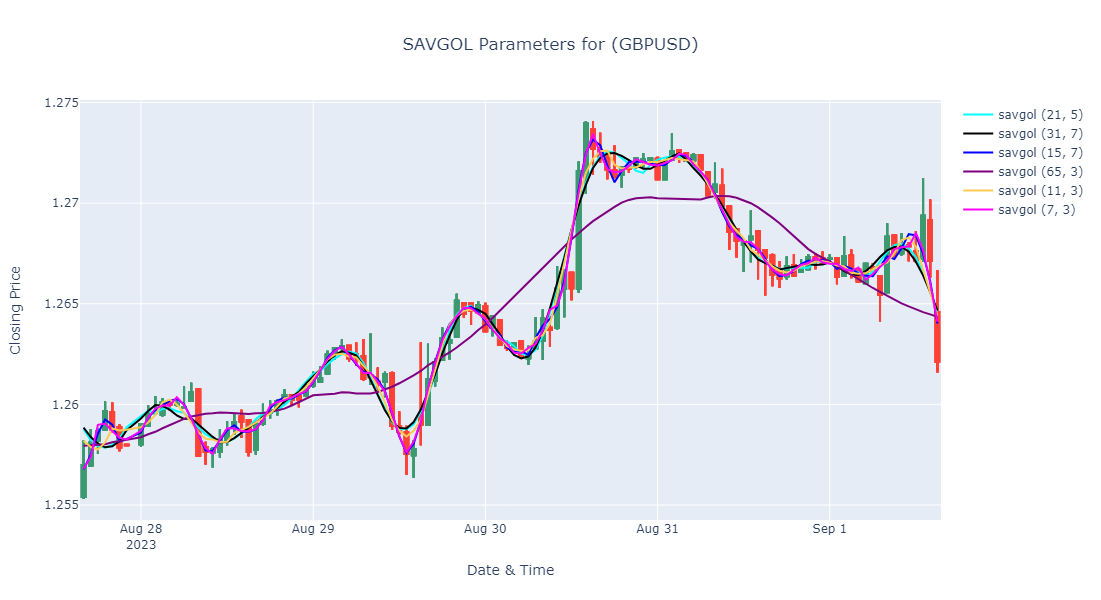

In [14]:
lst = [('cyan',(21,5)),('black',(31,7)),('blue',(15,7)),('purple',(65,3)),('dark orange',(11,3)),('magenta',(7,3))]
#lst = [('black',(21,5)),('magenta',(15,5)),('blue',(7,3))]
fig = define_plotly_subplots(1,1,0.7,[0.3])
n_data_points = int(0.9*len(ohlc_data))
for i in lst:
    #print(i)
    close_smooth = savgol_filter(ohlc_data.close,i[1][0], i[1][1],mode="nearest")
    #plot OHLC data & Smooth(noiseless) closing balace
    plot_ohlc_data(fig,ohlc_data[n_data_points:],1,1)
    #plot_df_column(fig,ohlc_data[n_data_points:],close_smooth[n_data_points:],1,1,'black',f'savgol({i[1][0], i[1][1]})')
    try:
        fig.add_trace(go.Scatter(x=ohlc_data[n_data_points:].index, 
                                 y=close_smooth[n_data_points:],
                                 line=dict(color=i[0]),
                                 name=f'savgol {i[1][0], i[1][1]}'), row=1, col=1)
        msg = f'Plotting savgol({i[1][0], i[1][1]}) successful'
        #print(msg)
    except Exception as err:
        msg = f'{err} plotting {data_col}'
        print(msg)
    label_axes(fig,'Date & Time','Closing Price',f'SAVGOL Parameters for ({trading_pair})',1,1)
#Remove some labels on the Legend
for trace in fig['data']:
    # hide some legend column names labeled as "trace 0"
    if trace['name'] ==None:trace['showlegend'] = False
fig_layout(fig,1120,600)
show_figure(fig)

a figure with (1) subplots initialized successfully
plotting Raw OHLC data on Closing Price
OHLC data plotted successfully
Plotting close_smooth successful
y-axes labelled successfully
x-axes labelled successfully
Title labelled successfully
layout set successfully
figure rendered successfully


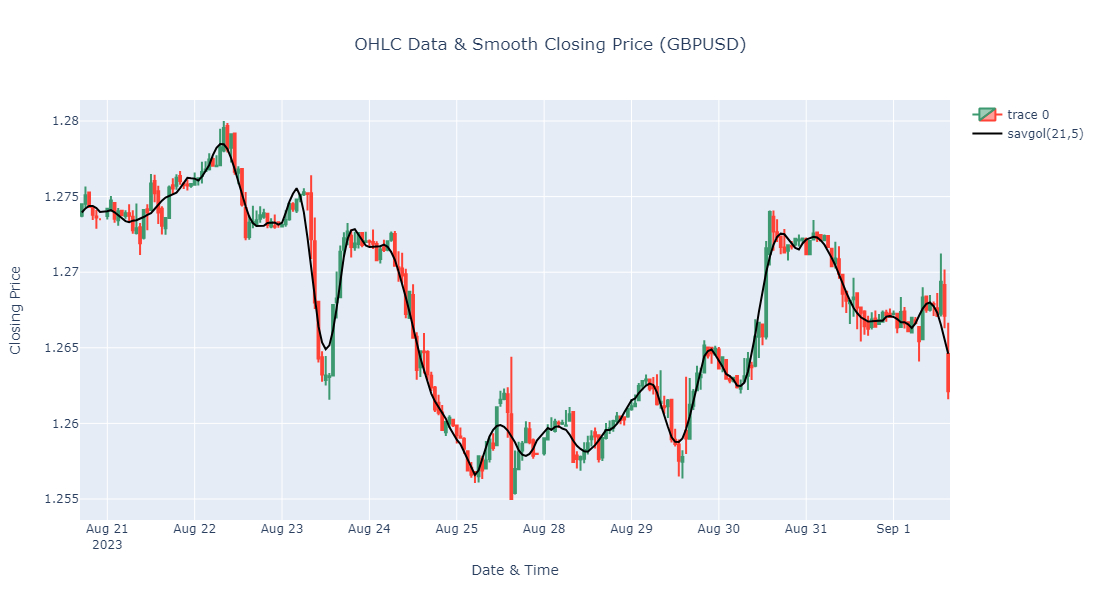

In [15]:
#plot OHLC data & Smooth(noiseless) closing balace
n_data_points = int(0.8*len(ohlc_data))
fig = define_plotly_subplots(1,1,0.7,[0.3])
plot_ohlc_data(fig,ohlc_data[n_data_points:],1,1)
plot_df_column(fig,ohlc_data[n_data_points:],'close_smooth',1,1,'black','savgol(21,5)')
label_axes(fig,'Date & Time','Closing Price',f'OHLC Data & Smooth Closing Price ({trading_pair})',1,1)
fig_layout(fig,1120,600)
show_figure(fig)

In [16]:
ohlc_data.describe()

open         high          low        close  Volume  Dividends  \
count  1183.000000  1183.000000  1183.000000  1183.000000  1183.0     1183.0   
mean      1.277893     1.278672     1.277122     1.277886     0.0        0.0   
std       0.012898     0.012881     0.012873     0.012914     0.0        0.0   
min       1.255400     1.256790     1.255000     1.255000     0.0        0.0   
25%       1.269865     1.270760     1.269250     1.269900     0.0        0.0   
50%       1.273760     1.274500     1.273110     1.273800     0.0        0.0   
75%       1.285220     1.285855     1.284455     1.285175     0.0        0.0   
max       1.313700     1.314270     1.313210     1.313940     0.0        0.0   

       Stock Splits        EMA50        EMA20  close_smooth  
count        1183.0  1134.000000  1164.000000   1183.000000  
mean            0.0     1.278220     1.278018      1.277885  
std             0.0     0.012294     0.012671      0.012873  
min             0.0     1.260500     1.258850      1.256600  
25%             0.0     1.270160     1.270040      1.270000  
50%             0.0     1.273645     1.273820      1.273670  
75%             0.0     1.285680     1.285038      1.285135  
max             0.0     1.308570     1.311250      1.313440

<h3><strong><center>Section(iv): Trading Strategies (1) </center></strong></h3>

<h4><strong><left>1) Average Directional Movement Index (ADX) : (Unoptimized)</left></strong></h4>

In [17]:
#Append ADX parameters to OHLC Test data
ohlc_test_data['plus_di'] = pd.DataFrame(compute_adx(ohlc_test_data['high'], ohlc_test_data['low'], ohlc_test_data['close'], 14)[0]).rename(columns = {0:'plus_di'})
ohlc_test_data['minus_di'] = pd.DataFrame(compute_adx(ohlc_test_data['high'], ohlc_test_data['low'], ohlc_test_data['close'], 14)[1]).rename(columns = {0:'minus_di'})
ohlc_test_data['adx'] = pd.DataFrame(compute_adx(ohlc_test_data['high'], ohlc_test_data['low'], ohlc_test_data['close'], 14)[2]).rename(columns = {0:'adx'})
ohlc_test_data = ohlc_test_data.dropna()
ohlc_test_data.tail()

open     high      low    close  Volume  \
Datetime                                                                
2023-09-01 11:00:00+01:00  1.26789  1.26807  1.26711  1.26786       0   
2023-09-01 12:00:00+01:00  1.26762  1.26862  1.26704  1.26712       0   
2023-09-01 13:00:00+01:00  1.26725  1.27123  1.26707  1.26937       0   
2023-09-01 14:00:00+01:00  1.26916  1.27018  1.26630  1.26712       0   
2023-09-01 15:00:00+01:00  1.26459  1.26666  1.26159  1.26212       0   

                           Dividends  Stock Splits    EMA50    EMA20  \
Datetime                                                               
2023-09-01 11:00:00+01:00        0.0           0.0  1.26736  1.26741   
2023-09-01 12:00:00+01:00        0.0           0.0  1.26735  1.26738   
2023-09-01 13:00:00+01:00        0.0           0.0  1.26743  1.26757   
2023-09-01 14:00:00+01:00        0.0           0.0  1.26741  1.26753   
2023-09-01 15:00:00+01:00        0.0           0.0  1.26721  1.26701   

                           close_smooth    plus_di   minus_di        adx  
Datetime                                                                  
2023-09-01 11:00:00+01:00       1.26775  23.566242  24.255523  13.921734  
2023-09-01 12:00:00+01:00       1.26732  23.914611  21.956948  13.044699  
2023-09-01 13:00:00+01:00       1.26653  30.336504  17.092728  12.538462  
2023-09-01 14:00:00+01:00       1.26558  24.381548  16.730098  13.589865  
2023-09-01 15:00:00+01:00       1.26461  19.430535  29.043292  13.954767

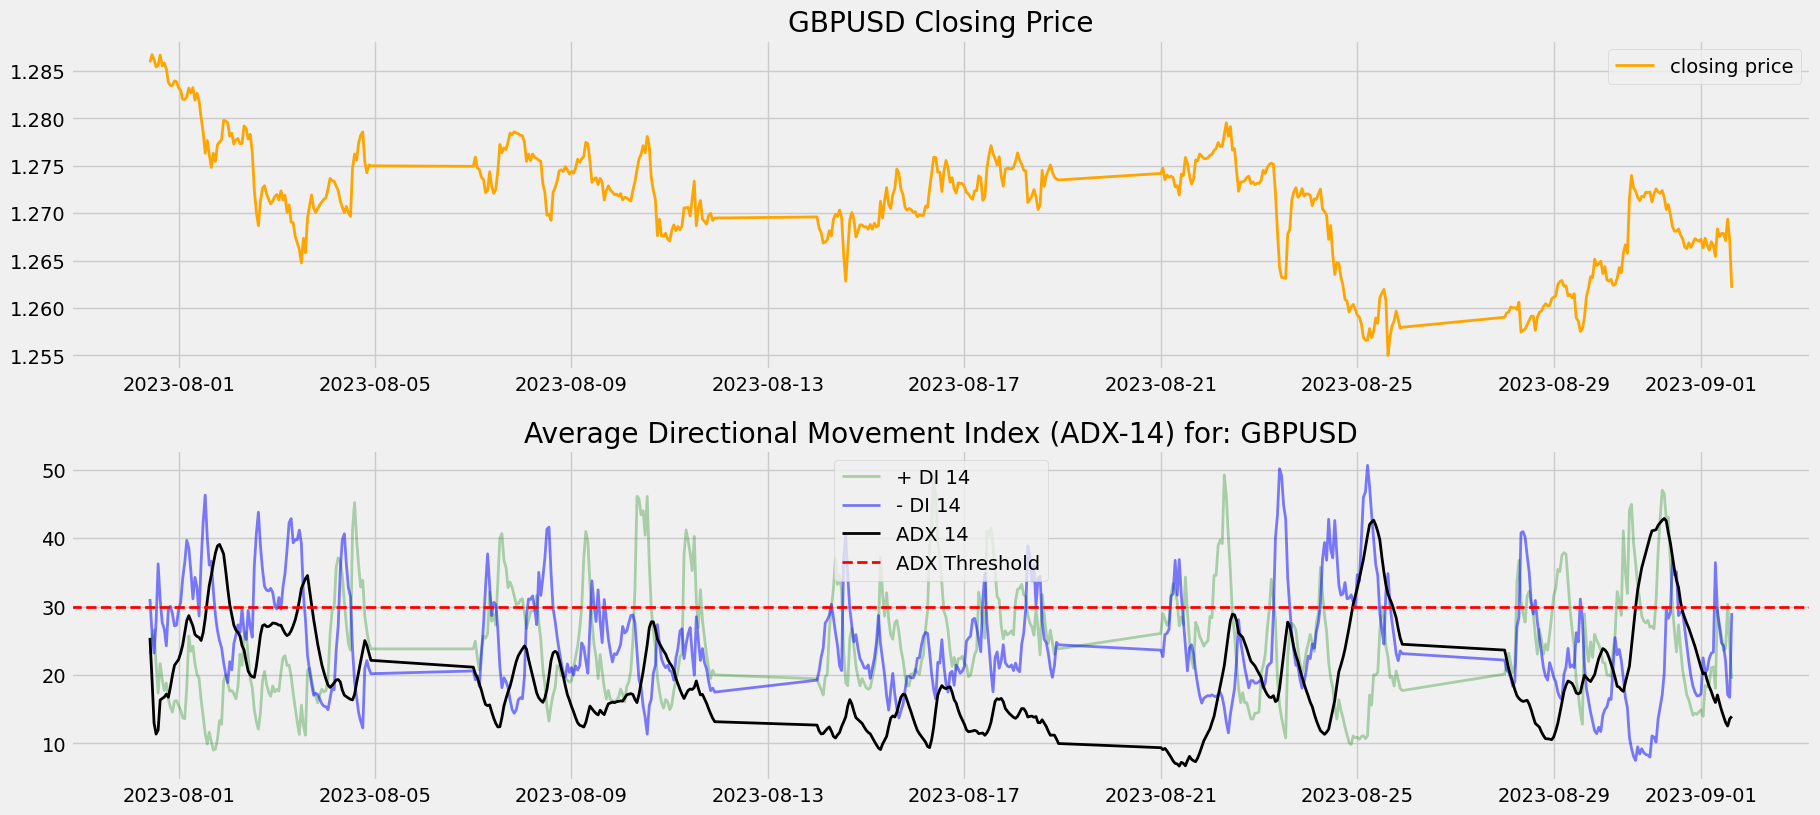

In [18]:
try:
    #initialize axes for closing balance and ADX repsectively
    ax1 = plt.subplot2grid((12,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((12,1), (6,0), rowspan = 5, colspan = 1)
    #Plot OHLC closing balance based on test data set
    ax1.plot(ohlc_test_data['close'], linewidth = 2, color = 'orange',label = 'closing price')
    ax1.set_title(f'{trading_pair} Closing Price')
    #plot Average Directional Movement Index (ADX) parameters
    ax2.plot(ohlc_test_data['plus_di'], color = 'Green', label = '+ DI 14', linewidth = 2, alpha = 0.3)
    ax2.plot(ohlc_test_data['minus_di'], color = 'blue', label = '- DI 14', linewidth = 2, alpha = 0.5)
    ax2.plot(ohlc_test_data['adx'], color = 'Black', label = 'ADX 14', linewidth = 2)
    ax2.axhline(adx_threshold, color = 'red', linewidth = 2, linestyle = '--',label='ADX Threshold')
    #append legends for both axes
    ax1.legend()
    ax2.legend()
    ax2.set_title(f'Average Directional Movement Index (ADX-14) for: {trading_pair}')
    #render the plots
    plt.show()
except Exception as err:
    print(err)

<h4><strong><left>Market Entry using ADX Strategy</left></strong></h4>

In [19]:
#get buy and sell signals based on ADX strategy (Market Entry)
buying_price, selling_price, adx_signal,buying_indices,selling_indices= adx_strategy_entry(ohlc_test_data['close'], ohlc_test_data['plus_di'], 
                                                           ohlc_test_data['minus_di'], ohlc_test_data['adx'],adx_threshold)

Plot showing trade entry (BUY & SELL) using un-optimised ADX Strategy


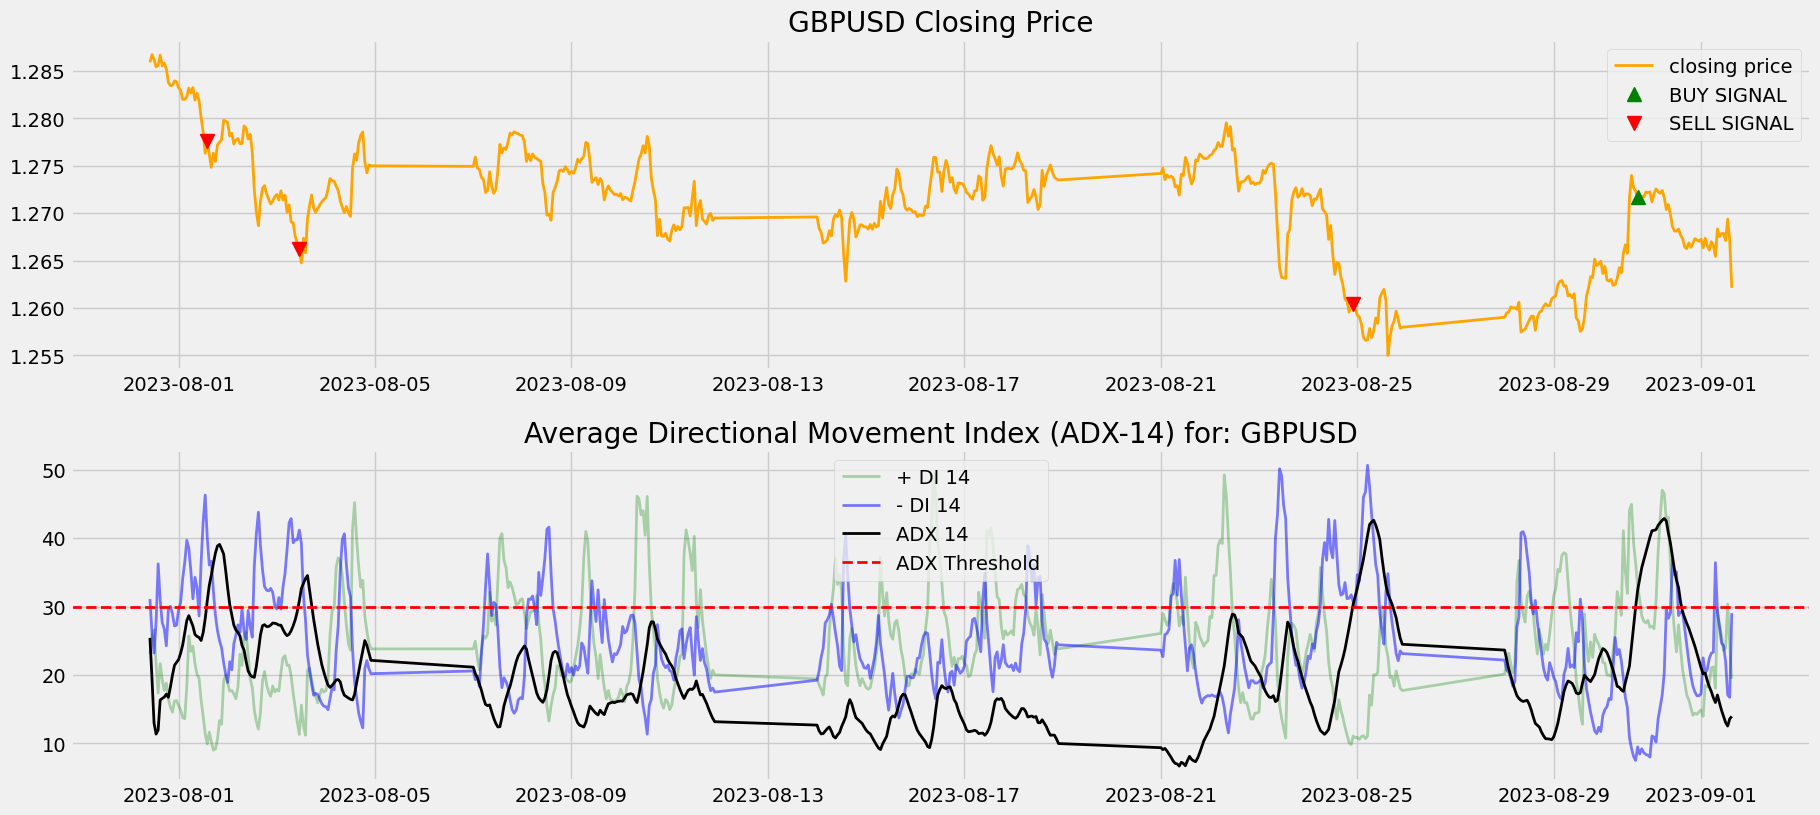

In [20]:
try:
    print('Plot showing trade entry (BUY & SELL) using un-optimised ADX Strategy')
    #initialize axes for closing balance and ADX repsectively
    ax1 = plt.subplot2grid((12,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((12,1), (6,0), rowspan = 5, colspan = 1)
    #Plot OHLC closing balance based on test data set
    ax1.plot(ohlc_test_data['close'], linewidth = 2, color = 'orange',label = 'closing price')
    ax1.set_title(f'{trading_pair} Closing Price')
    #plot trade entry points (buy & sell)
    ax1.plot(ohlc_test_data.index, buying_price, marker = '^', color = 'green', markersize = 10, linewidth = 0, label = 'BUY SIGNAL')
    ax1.plot(ohlc_test_data.index, selling_price, marker = 'v', color = 'red', markersize = 10, linewidth = 0, label = 'SELL SIGNAL')
    #plot Average Directional Movement Index (ADX) parameters
    ax2.plot(ohlc_test_data['plus_di'], color = 'Green', label = '+ DI 14', linewidth = 2, alpha = 0.3)
    ax2.plot(ohlc_test_data['minus_di'], color = 'blue', label = '- DI 14', linewidth = 2, alpha = 0.5)
    ax2.plot(ohlc_test_data['adx'], color = 'Black', label = 'ADX 14', linewidth = 2)
    ax2.axhline(adx_threshold, color = 'red', linewidth = 2, linestyle = '--',label='ADX Threshold')
    #append legends for both axes
    ax1.legend()
    ax2.legend()
    ax2.set_title(f'Average Directional Movement Index (ADX-14) for: {trading_pair}')
    #render the plots
    plt.show()
except Exception as err:
    print(err)

<h4><strong><left>Market Exit using ADX Strategy</left></strong></h4>

In [21]:
#initialize +DI and -DI series
plus_di = ohlc_test_data['plus_di']
minus_di = ohlc_test_data['minus_di']

In [22]:
#the trade exit function identifies buy/sell position and looks out for the next CROSS to exit the trade
trades_summary = adx_strategy_exit(ohlc_test_data,trading_pair,lot_size,buying_price,selling_price,plus_di,minus_di)

buy position; Trade Entry found
1.27167
cross found ;Trade Exit position
1.26751
Sell entry position; Trade Entry found
1.27766
cross found ;Sell Exit position
1.27972
Sell entry position; Trade Entry found
1.26618
cross found ;Sell Exit position
1.27078
Sell entry position; Trade Entry found
1.26038
cross found ;Sell Exit position
1.25914


In [23]:
#Create a copy of backtesting dataset 
#Rename OHLC columns to align with expected naming in backtesting module
ohlc_bt_data = ohlc_test_data.copy()
ohlc_bt_data = ohlc_bt_data.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close'})
#Convert index to datetime
ohlc_bt_data.index = pd.DatetimeIndex(ohlc_bt_data.index)      

In [24]:
##Append the adx unoptimised strategy entry signals(buy(2) and sell(1)) on the dataframe
#initialize buysell signals for adx strategy
ohlc_bt_data['adx_buysell_signal'] = 0
#append sell signals (1)
ohlc_bt_data.iloc[selling_indices,[13]] = 1
#append buy signals (2)
ohlc_bt_data.iloc[buying_indices,[13]] = 2

In [25]:
#generate the exit points for corresponding entry(buy & sell)
trade_exit_points,trade_exit_indices = gen_trade_exit_points(ohlc_test_data,trades_summary)

Plot showing trade entry (BUY & SELL) and corresponsing EXIT points on un-optimised ADX Strategy


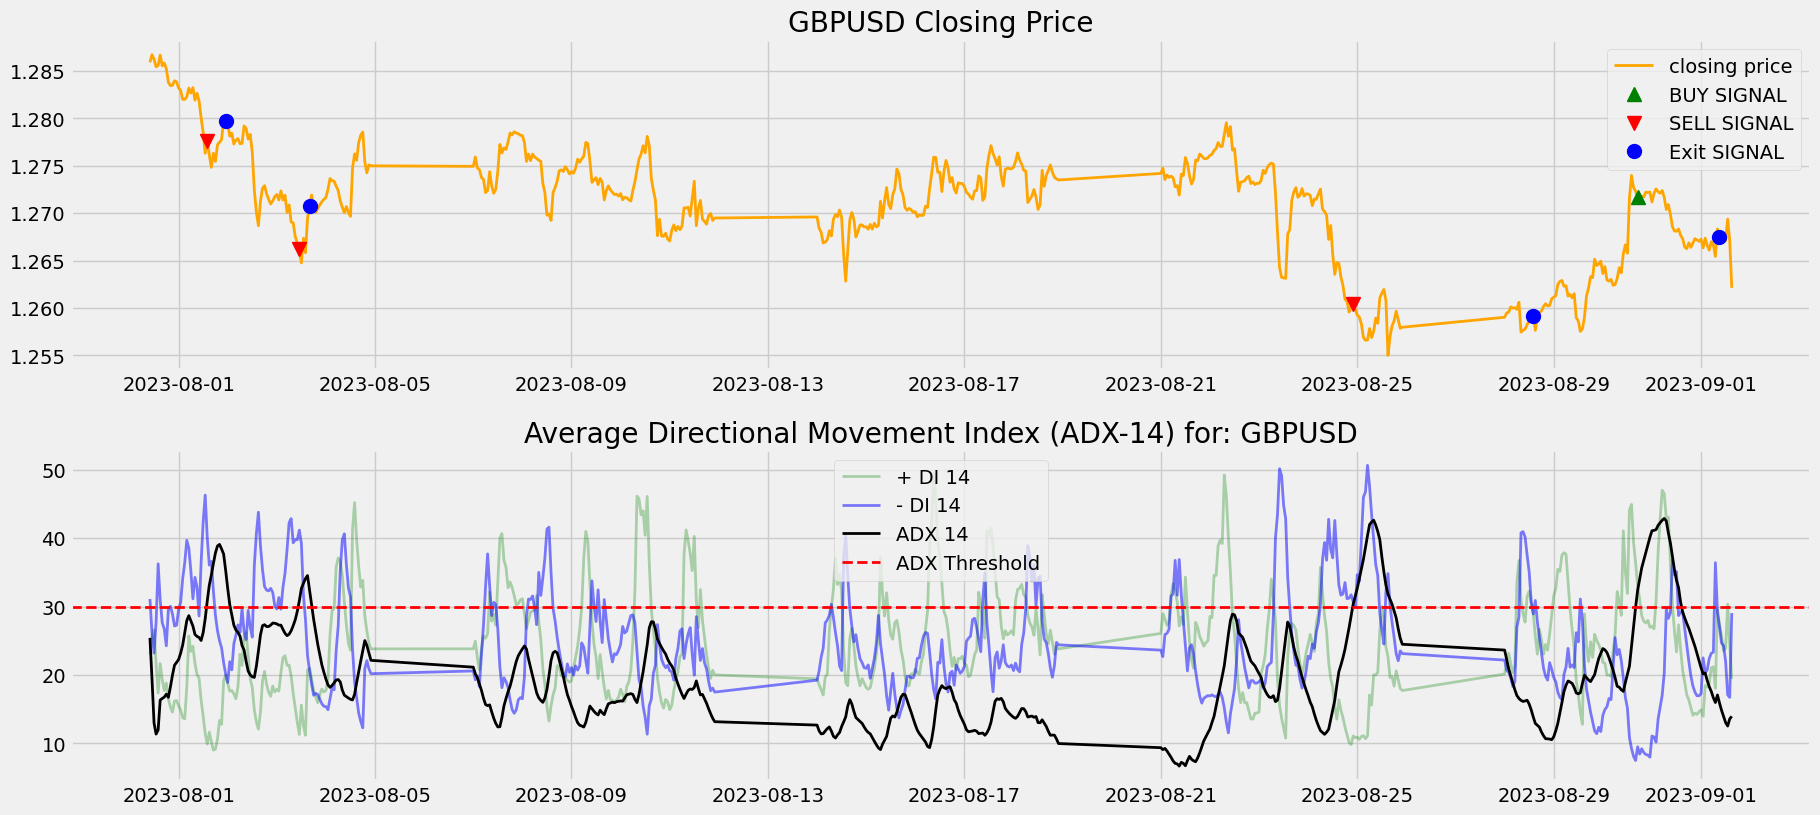

In [26]:
try:
    print('Plot showing trade entry (BUY & SELL) and corresponsing EXIT points on un-optimised ADX Strategy')
    #initialize axes for closing balance and ADX repsectively
    ax1 = plt.subplot2grid((12,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((12,1), (6,0), rowspan = 5, colspan = 1)
    #Plot OHLC closing balance based on test data set
    ax1.plot(ohlc_test_data['close'], linewidth = 2, color = 'orange',label = 'closing price')
    ax1.set_title(f'{trading_pair} Closing Price')
    #plot trade entry points (buy & sell)
    ax1.plot(ohlc_test_data.index, buying_price, marker = '^', color = 'green', markersize = 10, linewidth = 0, label = 'BUY SIGNAL')
    ax1.plot(ohlc_test_data.index, selling_price, marker = 'v', color = 'red', markersize = 10, linewidth = 0, label = 'SELL SIGNAL')
    #Mark exit signal
    ax1.plot(ohlc_test_data.index, trade_exit_points, marker = 'o', color = 'blue', markersize = 10, linewidth = 0, label = 'Exit SIGNAL')
    #plot Average Directional Movement Index (ADX) parameters
    ax2.plot(ohlc_test_data['plus_di'], color = 'Green', label = '+ DI 14', linewidth = 2, alpha = 0.3)
    ax2.plot(ohlc_test_data['minus_di'], color = 'blue', label = '- DI 14', linewidth = 2, alpha = 0.5)
    ax2.plot(ohlc_test_data['adx'], color = 'Black', label = 'ADX 14', linewidth = 2)
    ax2.axhline(adx_threshold, color = 'red', linewidth = 2, linestyle = '--',label='ADX Threshold')
    #append legends for both axes
    ax1.legend()
    ax2.legend()
    ax2.set_title(f'Average Directional Movement Index (ADX-14) for: {trading_pair}')
    #render the plots
    plt.show()
except Exception as err:
    print(err)

In [27]:
#Append the adx unoptimised strategy exit signals on the dataframe
#initialize buysell signals for adx strategy
ohlc_bt_data['adx_exit_signal'] = 0
#append exit signals (1)
ohlc_bt_data.iloc[trade_exit_indices,[14]] = 1

In [28]:
#backtesting unoptimised ADX strategy
bt = Backtest(ohlc_bt_data, unoptimized_adx_strategy, cash=100, margin=1/100, commission=.00)
stat = bt.run()
stat      

Start                     2023-07-31 10:00...
End                       2023-09-01 15:00...
Duration                     32 days 05:00:00
Exposure Time [%]                   16.782007
Equity Final [$]                     67.08458
Equity Peak [$]                      116.8044
Return [%]                          -32.91542
Buy & Hold Return [%]               -1.850052
Return (Ann.) [%]                  -98.212044
Volatility (Ann.) [%]                2.452095
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -48.143828
Avg. Drawdown [%]                  -48.143828
Max. Drawdown Duration       30 days 23:00:00
Avg. Drawdown Duration       30 days 23:00:00
# Trades                                    4
Win Rate [%]                             25.0
Best Trade [%]                       0.080937
Worst Trade [%]                     -0.444328
Avg. Trade [%]                    

<h3><strong><center>Section(v): Machine Learning Model (ARIMA)</center></strong></h3>

In [29]:
#ectract closing smoothed balance and convert to dataframe
ohlc_train_data_ar = ohlc_train_data['close_smooth'].to_frame()
ohlc_test_data_ar = ohlc_test_data['close_smooth'].to_frame()      

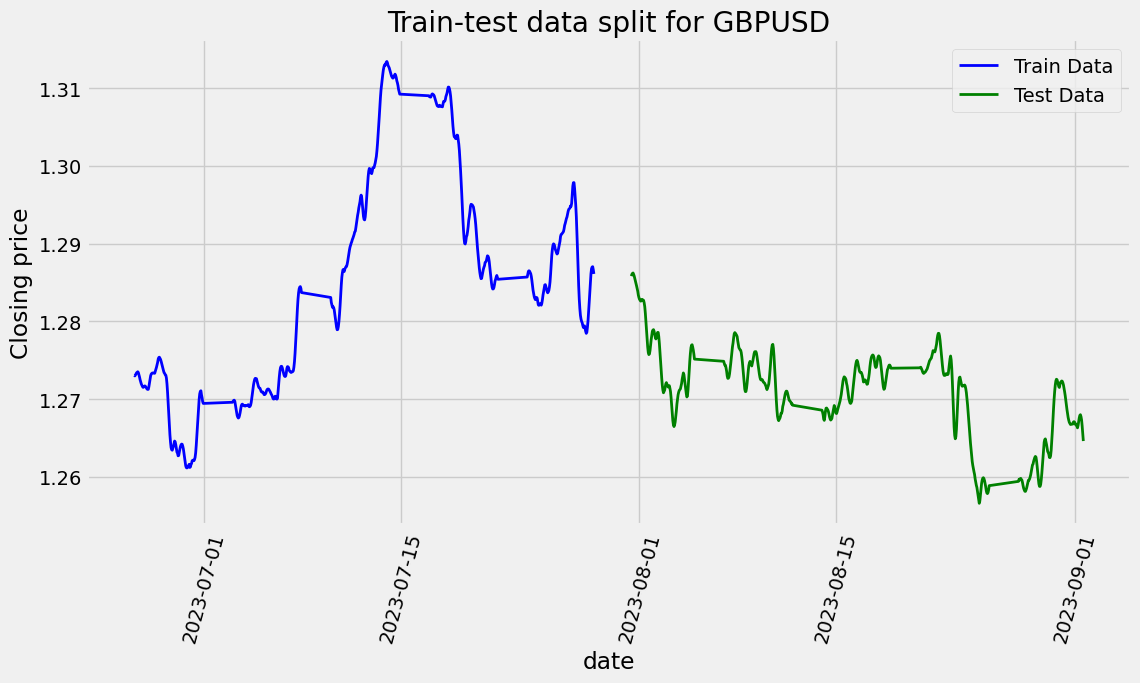

In [30]:
#Note that; the gap between train and test data is due to dropna (step above) while generating ADX values
try:
    #visualizing training and test sets for ARIMA model
    plt.figure(figsize=(12,6))
    #label the axes
    plt.xlabel('date')
    plt.ylabel('Closing price')
    #plot training dataset
    plt.plot(ohlc_train_data_ar['close_smooth'],color='blue',label='Train Data',linewidth=2)
    #plot testing dataset
    plt.plot(ohlc_test_data_ar['close_smooth'],color='green',label='Test Data',linewidth=2)
    plt.xticks(rotation=75)
    #set plot title
    plt.title(f'Train-test data split for {trading_pair}')
    #show legend
    plt.legend()
    #render the plot
    plt.show()
except Exception as err:
    print(err)

a figure with (1) subplots initialized successfully
Plotting close_smooth successful
y-axes labelled successfully
x-axes labelled successfully
Title labelled successfully
figure rendered successfully


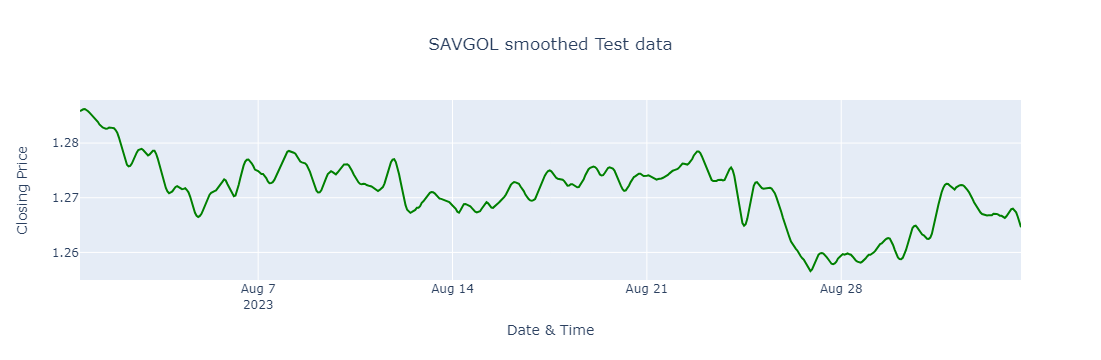

In [31]:
#plot OHLC data & Smooth(noiseless) closing balace
fig = define_plotly_subplots(1,1,0.7,[0.3])
plot_df_column(fig,ohlc_test_data_ar,'close_smooth',1,1,'green','smooth Close price')
label_axes(fig,'Date & Time','Closing Price','SAVGOL smoothed Test data',1,1)
show_figure(fig)

a figure with (1) subplots initialized successfully
Plotting close_smooth successful
y-axes labelled successfully
x-axes labelled successfully
Title labelled successfully
figure rendered successfully


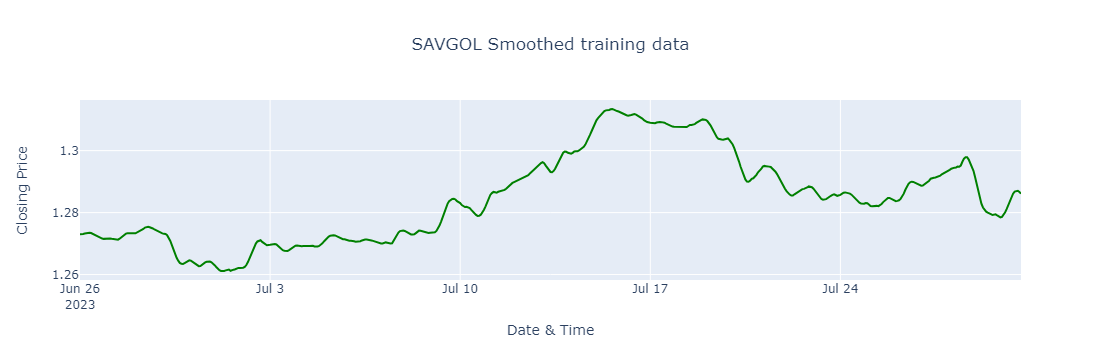

In [32]:
#plot OHLC data & Smooth(noiseless) closing balace
fig = define_plotly_subplots(1,1,0.7,[0.3])
plot_df_column(fig,ohlc_train_data_ar,'close_smooth',1,1,'green','smooth closing price')
label_axes(fig,'Date & Time','Closing Price','SAVGOL Smoothed training data',1,1)
show_figure(fig)

<h4><strong><left>Stationarity</left></strong></h4>

In [33]:
check_stationarity(ohlc_data,'close')

ADF Statistic: -1.550088
p-value: 0.508604
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568

The data is Non-stationary


In [34]:
#Its non stationary so we takd first diff coz the p-value is bigger than 0.05
ohlc_data['first_diff'] = ohlc_data['close']-ohlc_data['close'].shift()

In [35]:
check_stationarity(ohlc_data,'first_diff')

ADF Statistic: -30.691031
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568

The Data is stationary


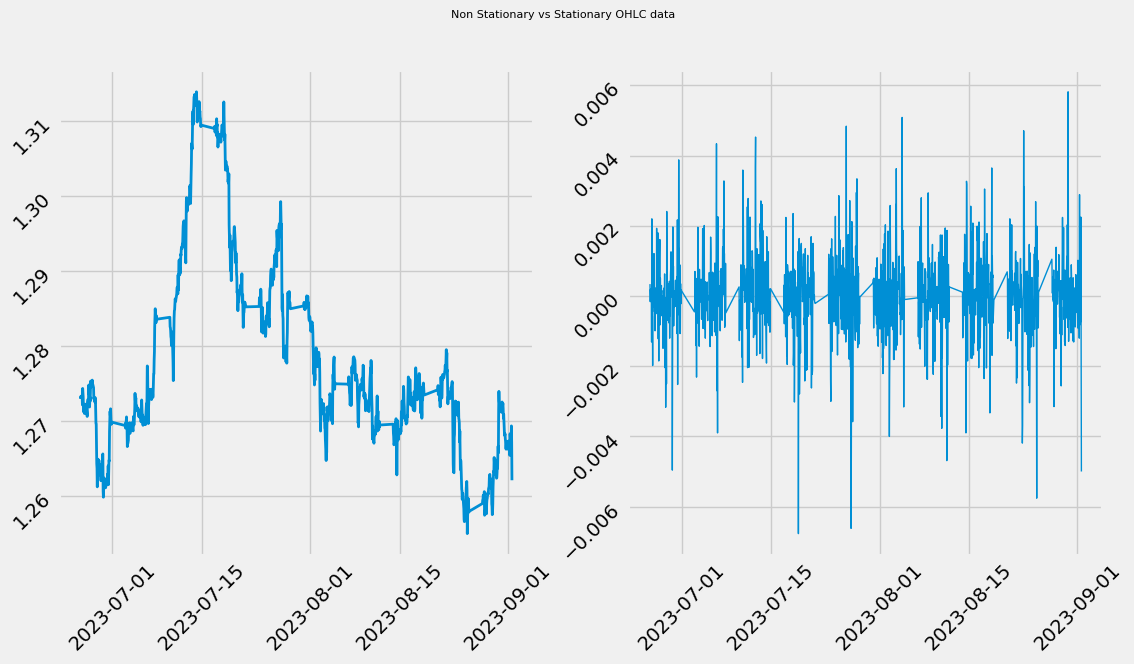

In [36]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.plot(ohlc_data['close'],linewidth=2)
ax2.plot(ohlc_data['first_diff'],linewidth=1)
fig.suptitle('Non Stationary vs Stationary OHLC data', fontsize=8)
ax1.tick_params(labelrotation=45)
ax2.tick_params(labelrotation=45)
plt.show()

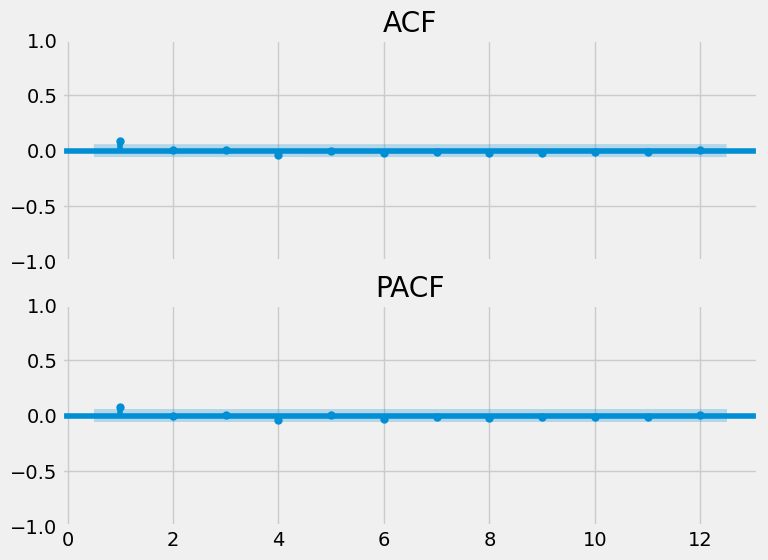

In [37]:
ohlc_data = ohlc_data.dropna()

# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,6),sharex=True)
# Make ACF plot
plot_acf(ohlc_data.first_diff, lags=12, zero=False, ax=ax1,title='ACF')
# Make PACF plot
plot_pacf(ohlc_data.first_diff, lags=12, method='ywm', zero=False, ax=ax2, title='PACF')
plt.show()

<h4><strong><left>Lag-plot</left></strong></h4>

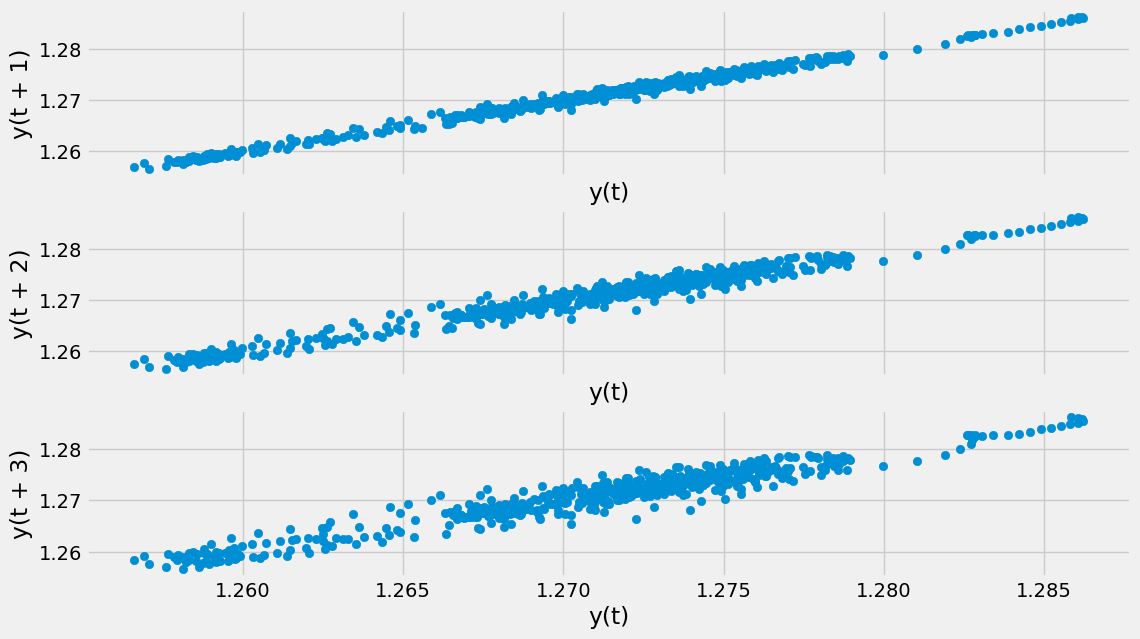

In [38]:
# define a figure
fig, (ax1, ax2,ax3) = plt.subplots(3,1, figsize=(12,7),sharex=True)
# lag plot for lag=1
lag_plot(ohlc_test_data_ar['close_smooth'], lag=1,ax=ax1)
# lag plot for lag=2
lag_plot(ohlc_test_data_ar['close_smooth'], lag=2,ax=ax2)
# lag plot for lag=3
lag_plot(ohlc_test_data_ar['close_smooth'], lag=3,ax=ax3)
plt.show()

<h4><strong><left>Derive ARIMA (p,d,q) Order using Auto-arima</left></strong></h4>

In [39]:
#Generate arima Order using auto-arima
Order = generate_order_of_arima(ohlc_train_data_ar)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-8451.156, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7176.133, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8292.874, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7174.090, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7177.181, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-8416.630, Time=0.60 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-8453.340, Time=0.50 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8393.284, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-8438.858, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-8439.159, Time=0.30 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-8450.067, Time=0.41 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-8450.140, Time=0.72 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-8455.251, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-8395.357, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0

In [40]:
print(len(ohlc_train_data_ar))

591


In [41]:
#add hourly period to the datasets
try:
    add_freq_df_index(ohlc_train_data_ar,'H')
    add_freq_df_index(ohlc_test_data_ar,'H')
except Exception as err:
    print(err)

C:\Users\a212841\AppData\Local\Temp\ipykernel_6388\3977739949.py:689: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



In [42]:
#extend testdataset to include future forecast period
test_data,future_dates = add_forecast_parms(len_future_forecast,ohlc_test_data_ar)

forecast starts at 2023-09-01 15:00 for length period of: 1
1 forecast period appended/extended on test data


<h4><strong><left>Training ARIMA Model</left></strong></h4>

In [43]:
#Order = (3,1,5)
#Order = (2,1,1)

In [44]:
#Train and forecast using ARIMA model
try:
    model_fit,test_data,model_predictions = train_and_forecast(ohlc_train_data_ar,ohlc_test_data_ar,Order)
except Exception as err:
    print(err)

D:\projects\XY03222\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

D:\projects\XY03222\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

D:\projects\XY03222\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

D:\projects\XY03222\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

D:\projects\XY03222\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

D:\projects\XY03222\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

D:\p

2023-08-02 11:00    1.272949
Freq: H, dtype: float64
1.2729490754981307


D:\projects\XY03222\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

D:\projects\XY03222\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

D:\projects\XY03222\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

D:\projects\XY03222\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

D:\projects\XY03222\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

D:\projects\XY03222\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

D:\p

In [45]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           close_smooth   No. Observations:                 1168
Model:                 ARIMA(2, 1, 1)   Log Likelihood                8381.297
Date:                Fri, 29 Sep 2023   AIC                         -16754.593
Time:                        19:25:07   BIC                         -16734.344
Sample:                    06-26-2023   HQIC                        -16746.955
                         - 08-21-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6629      0.009    181.283      0.000       1.645       1.681
ar.L2         -0.7715      0.010    -73.649      0.000      -0.792      -0.751
ma.L1         -0.3689      0.013    -28.404      0.0

<h4><strong><left>Visualize Observed vs Predicted and future forecast</left></strong></h4>

Visualizing Model prediction & Forecasting


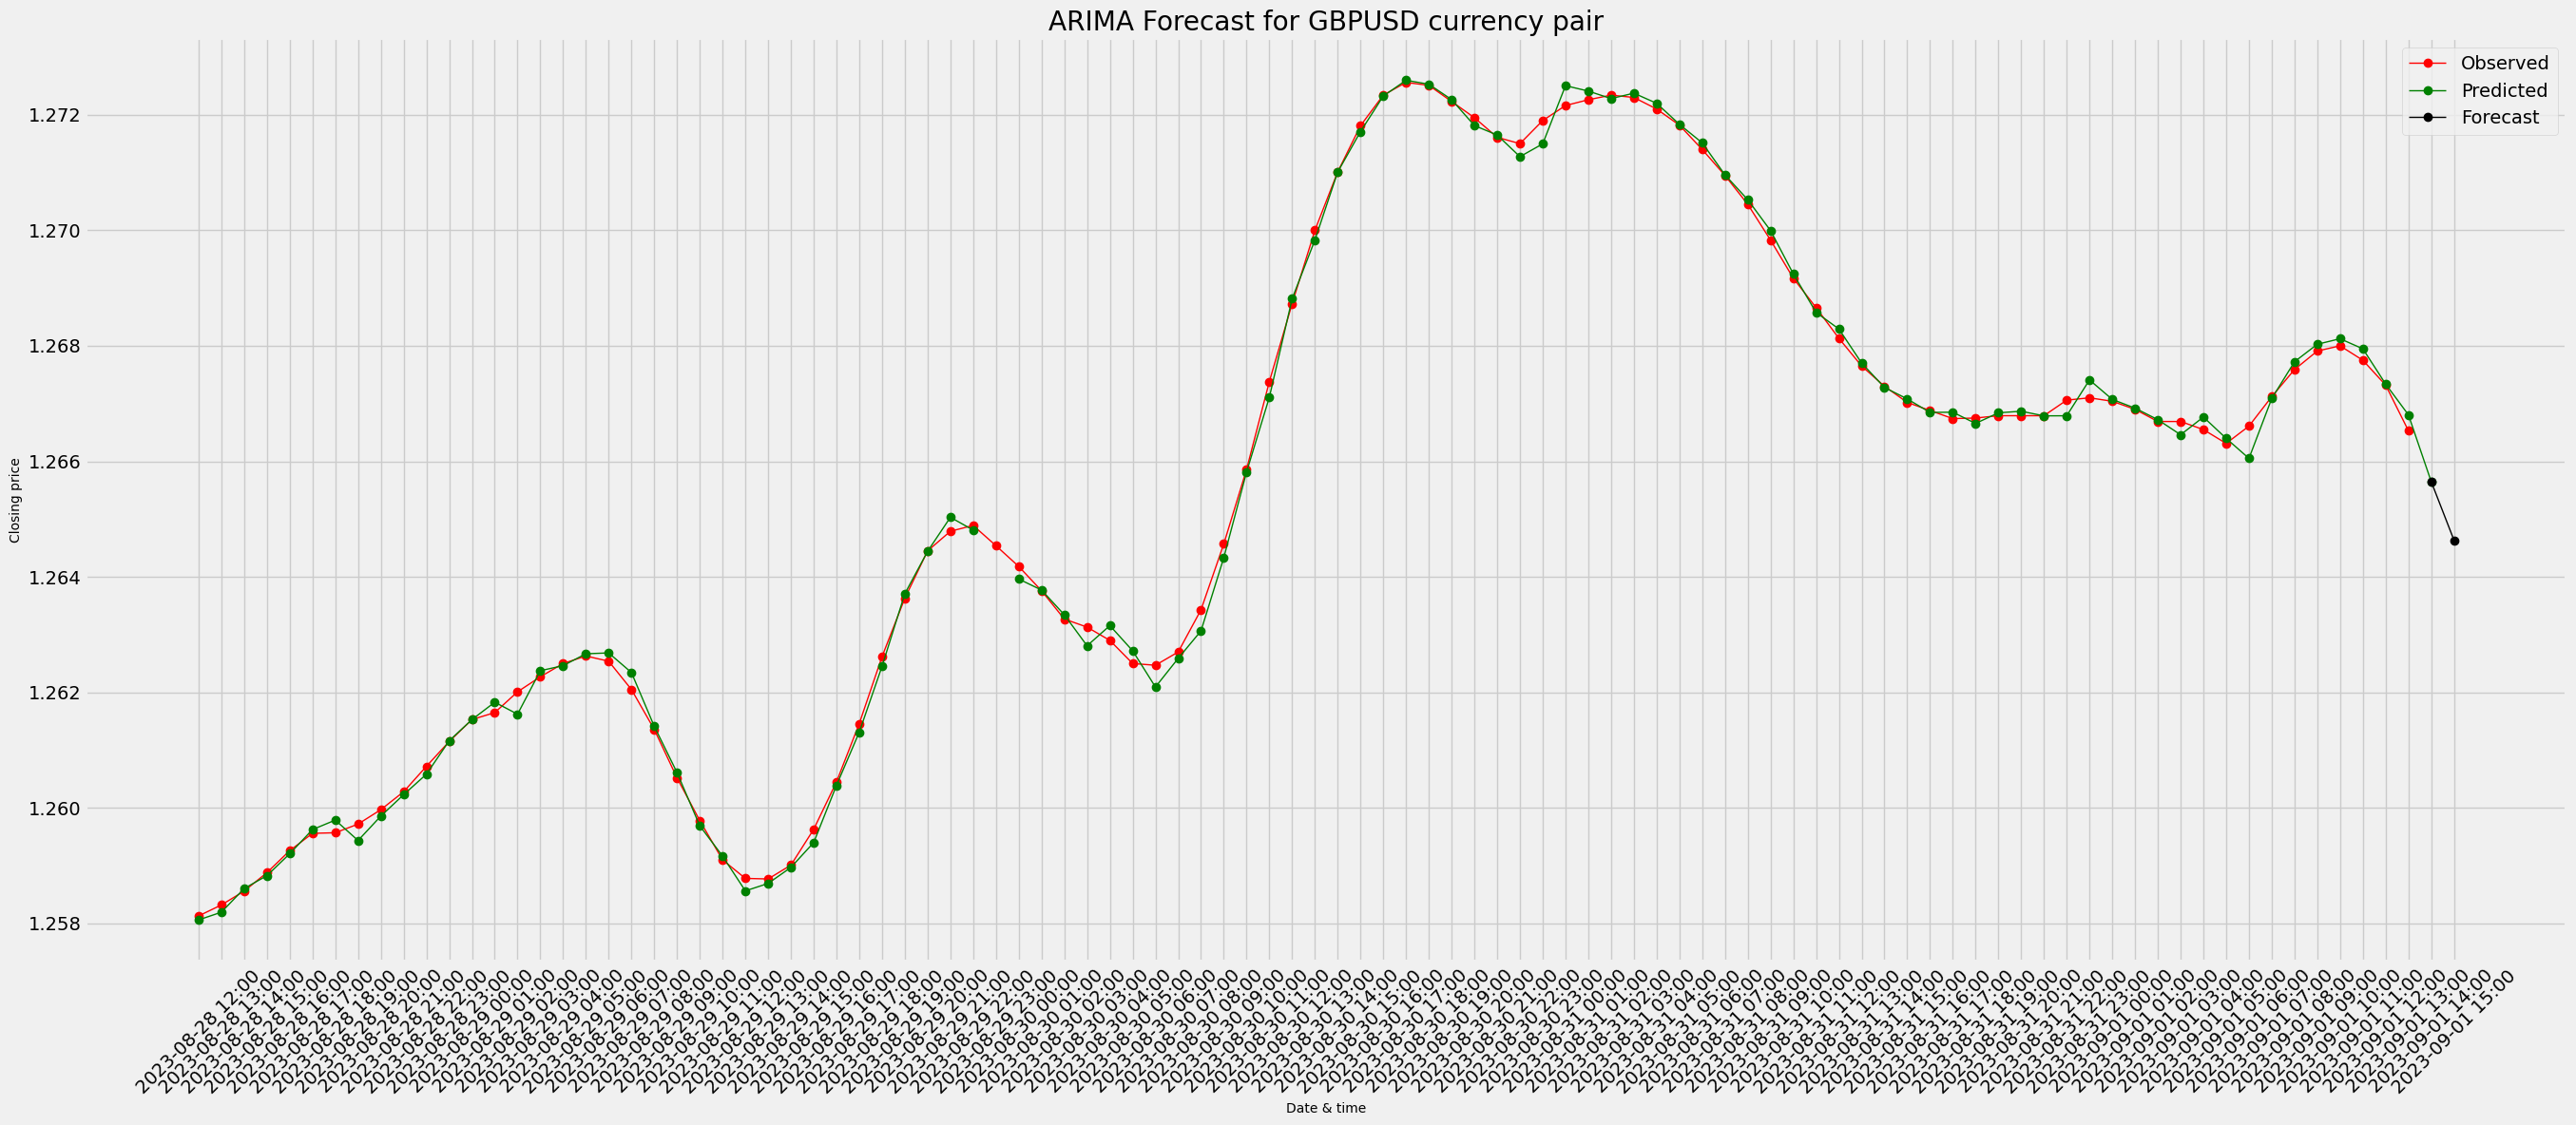

In [46]:
#visualize Model output
arima_model_viz(model_predictions[-100:],ohlc_test_data_ar[-100:].close_smooth,len_future_forecast,trading_pair)
#visualize Model output
#arima_model_viz(model_predictions,ohlc_test_data_ar.close_smooth,len_future_forecast,trading_pair)

<h4><strong><left>ARIMA Model Peformance</left></strong></h4>

In [47]:
ARIMA_peformance(ohlc_test_data_ar,model_predictions,len_future_forecast)

Model Performance Metrics
*************************
MAPE   : 0.00011
MAPE % : 0.01082 %
*************************
RMSE: 0.00018
**************************************
Mean Absolute Error (MAE) is : 0.00014
**************************************


Model Diagnostics


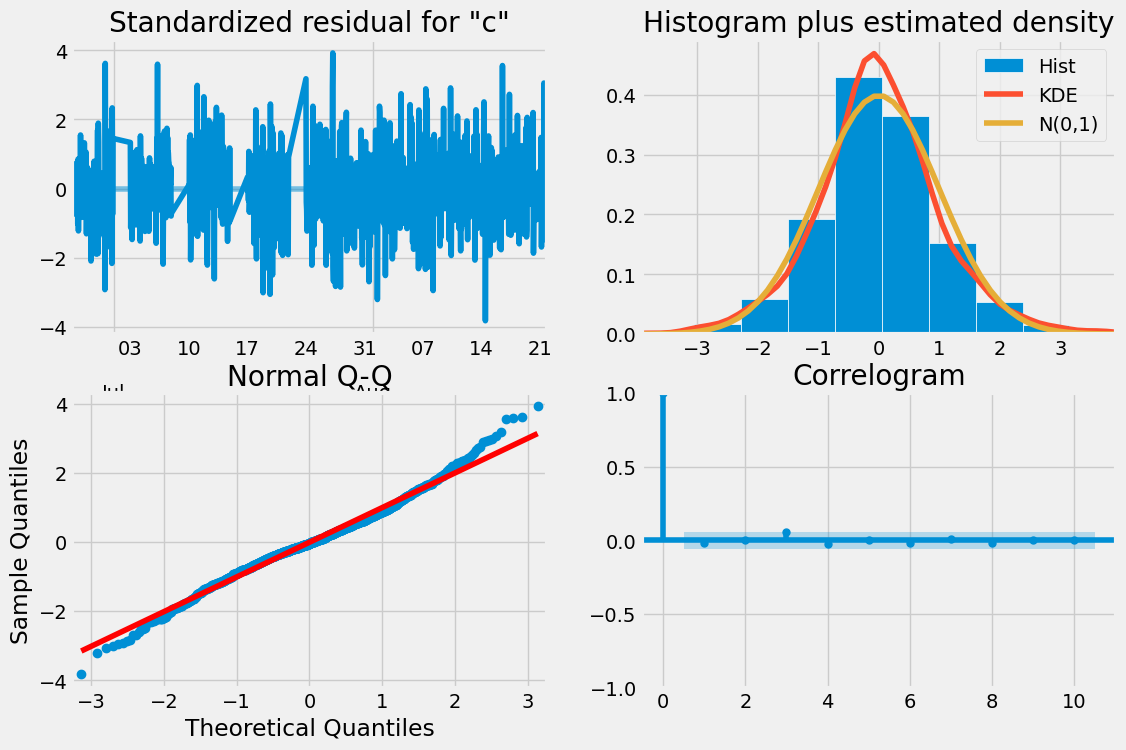

In [48]:
print('Model Diagnostics')
model_fit.plot_diagnostics(figsize=(12, 8));

<h3><strong><center>Section (vi): Optimizing ADX Trading strategy</center></strong></h3>

<h4><strong><left>Generate optimized ADX trade exit based on ARIMA Model predictions</left></strong></h4>

In [49]:
#trend value 1=uptrend, 0=flat-trend, -1=downtrend
#initlize index and trend list
idx = -1
trend = []
#loop through ARIMA model predictions and derive the trends based on previous and current values
for prev, curr, nxt in get_prev_next_pred(model_predictions):
    #print(f'current value is {curr}, next value is, {nxt}, and previous value is, {prev}')
    if prev != None:
        if round(curr,4)>round(prev,4):
            #predicted up-trend
            trend.append((idx,curr,1))
        elif round(curr,4)==round(prev,4):
            #predicted No-trend
            trend.append((idx,curr,0))
        else:
            #predicted down-trend
            trend.append((idx,curr,-1))
    idx+=1

In [50]:
#initialize summary list and arima exit price
trades_summary=[]
arima_exit_price = []
adx_ar_exit_price = []
#initalize lists to hold arima trend at buy and sell entry
adx_sell_signal = []
adx_buy_signal = []
#initialize list to hold optimized arima entry point (buy and sell)
adx_ar_buy = []
adx_ar_sell=[]
#drop NAN values from the lists
selling_price_lst = [x for x in selling_price if ~np.isnan(x)]
buying_price_lst = [x for x in buying_price if ~np.isnan(x)]
#convert index to timestamps
ohlc_test_data_ar.index = ohlc_test_data_ar.index.to_timestamp()

In [51]:
for buy_signal,buy_price in zip(buying_indices,buying_price_lst):
    trade_type = 'B'
    print(f'buy signal at {buy_signal}')
    for predicted_trend in trend:
        #check for predictions after buy signal index
        if predicted_trend[0]>buy_signal:
            #if the trend is not an uptrend
            if predicted_trend[2]!=1:
                print(predicted_trend)
                #note that we will append the price from non-smoothed/original test set
                #this will help is visualizing exit position more precisely and simulate real trading scenario
                #(-1) since indices start at 0 while trend starts from 1 :)
                arima_exit_price.append((predicted_trend[0],ohlc_test_data.iloc[predicted_trend[0]].close))
                #append trade summary details based on ARIMA forecasting
                trade_summary_tpl = tuple((trading_pair,trade_type,lot_size,ohlc_test_data_ar.index[buy_signal].strftime('%m-%d-%Y, %H:%M:%S'),ohlc_test_data_ar.index[predicted_trend[0]].strftime('%m-%d-%Y, %H:%M:%S'),buy_price,round(predicted_trend[1],3)))
                trades_summary.append(trade_summary_tpl)
                adx_buy_signal.append(buy_signal)
                #diff between suggested trade entry and change of trend should be more than 1 unit
                if int(predicted_trend[0])-int(buy_signal)>1:
                    adx_ar_buy.append(buy_signal)
                    adx_ar_exit_price.append(predicted_trend[0])
                break

buy signal at 531
(532, 1.2716497721665248, -1)


In [52]:
#Using ARIMA to validate if the buy signal was a good decision
try:
    for i in adx_buy_signal:
        print(f'**Checking the trend at ADX (buy) trade entry index: {i} **')
        cur_pred_trend = trend[i][2]
        nxt_pred_trend = trend[i+1][2]
        if cur_pred_trend ==1 and nxt_pred_trend==1:
            print(f'up-trend is predicted ideal for buy')
        elif cur_pred_trend ==1 and nxt_pred_trend==0:
            print(f'flat trend is predicted no decision')
        elif cur_pred_trend ==1 and nxt_pred_trend==-1:
            print(f'down-trend is predicted ideal for sell')
        elif cur_pred_trend ==0 and nxt_pred_trend==1:
            print(f'up-trend predicted ideal for buy')
        elif cur_pred_trend ==0 and nxt_pred_trend==0:
            print(f'flat trend is predicted no decision')
        elif cur_pred_trend ==0 and nxt_pred_trend==-1:
            print(f'down-trend is predicted ideal for sell')
        elif cur_pred_trend ==-1 and nxt_pred_trend==1:
            print(f'up-trend predicted ideal for buy')
        elif cur_pred_trend ==-1 and nxt_pred_trend==0:
            print(f'flat trend is predicted no decision')
        elif cur_pred_trend ==-1 and nxt_pred_trend==-1:
            print(f'down-trend is predicted ideal for sell')
except Exception as err:
    print(err)

**Checking the trend at ADX (buy) trade entry index: 531 **
down-trend is predicted ideal for sell


In [53]:
for sell_signal,sell_price in zip(selling_indices,selling_price_lst):
    trade_type = 'S'
    print(f'sell signal at {sell_signal}')
    for predicted_trend in trend:
        #check for predictions after sell signal index
        if predicted_trend[0]>sell_signal:
            #if the trend is not a down-trend
            if predicted_trend[2]!=-1:
                print(predicted_trend)
                #note that we will append the price from non-smoothed/original test set
                #this will help is visualizing exit position more precisely and simulate real world scenario 
                arima_exit_price.append((predicted_trend[0],ohlc_test_data.iloc[predicted_trend[0]].close))
                #append trade summary details based on ARIMA forecasting
                trade_summary_tpl = tuple((trading_pair,trade_type,lot_size,ohlc_test_data_ar.index[sell_signal].strftime('%m-%d-%Y, %H:%M:%S'),ohlc_test_data_ar.index[predicted_trend[0]].strftime('%m-%d-%Y, %H:%M:%S'),sell_price,round(predicted_trend[1],3)))
                trades_summary.append(trade_summary_tpl)
                adx_sell_signal.append(sell_signal)
                #diff between suggested trade entry and change of trend should be more than 1 unit
                if int(predicted_trend[0])-int(sell_signal)>1:
                    adx_ar_sell.append(sell_signal)
                    adx_ar_exit_price.append(predicted_trend[0])
                break

sell signal at 28
(30, 1.2756987130851056, 1)
sell signal at 73
(74, 1.2670910764634122, 1)
sell signal at 441
(448, 1.2575147896967742, 1)


In [54]:
#Using ARIMA to validate if the sell signal was a good decision
try:
    for i in adx_sell_signal:
        print(f'**Checking the trend at ADX (sell) trade entry index: {i} **')
        cur_pred_trend = trend[i][2]
        nxt_pred_trend = trend[i+1][2]
        if cur_pred_trend ==1 and nxt_pred_trend==1:
            print(f'up-trend predicted ideal for buy')
        elif cur_pred_trend ==1 and nxt_pred_trend==0:
            print(f'flat trend is predicted no decision')
        elif cur_pred_trend ==1 and nxt_pred_trend==-1:
            print(f'down-trend is predicted ideal for sell')
        elif cur_pred_trend ==0 and nxt_pred_trend==1:
            print(f'up-trend predicted ideal for buy')
        elif cur_pred_trend ==0 and nxt_pred_trend==0:
            print(f'flat trend is predicted no decision')
        elif cur_pred_trend ==0 and nxt_pred_trend==-1:
            print(f'down-trend is predicted ideal for sell')
        elif cur_pred_trend ==-1 and nxt_pred_trend==1:
            print(f'up-trend predicted ideal for buy')
        elif cur_pred_trend ==-1 and nxt_pred_trend==0:
            print(f'flat trend is predicted no decision')
        elif cur_pred_trend ==-1 and nxt_pred_trend==-1:
            print(f'down-trend is predicted ideal for sell')
except Exception as err:
    print(err)

**Checking the trend at ADX (sell) trade entry index: 28 **
down-trend is predicted ideal for sell
**Checking the trend at ADX (sell) trade entry index: 73 **
up-trend predicted ideal for buy
**Checking the trend at ADX (sell) trade entry index: 441 **
down-trend is predicted ideal for sell


In [55]:
#trades_summary

In [56]:
arima_exit_price_list = [np.nan for i in range(len(ohlc_test_data))]

In [57]:
idx = [i for i,j in arima_exit_price]
closing_prices = [j for i,j in arima_exit_price]
for b, c in zip(idx, closing_prices):
    setitem(arima_exit_price_list, b, c)

In [58]:
print(adx_ar_exit_price)
print(adx_ar_buy)
print(adx_ar_sell)

[30, 448]
[]
[28, 441]


In [59]:
#create optimized signal column
ohlc_bt_data['adx_ar_buysell_signal'] = 0
#append optimized sell signals (1)
ohlc_bt_data.iloc[adx_ar_sell,[15]] = 1
#append optimized buy signals (2)
ohlc_bt_data.iloc[adx_ar_buy,[15]] = 2
#create column for optimized strategy exit signals
ohlc_bt_data['adx_ar_exit_signal'] = 0
#set actual exit signals on the list as 1
ohlc_bt_data.iloc[adx_ar_exit_price,[16]] = 1

Plot showing trade entry (BUY & SELL) and ARIMA EXIT points on Optimised ADX Strategy


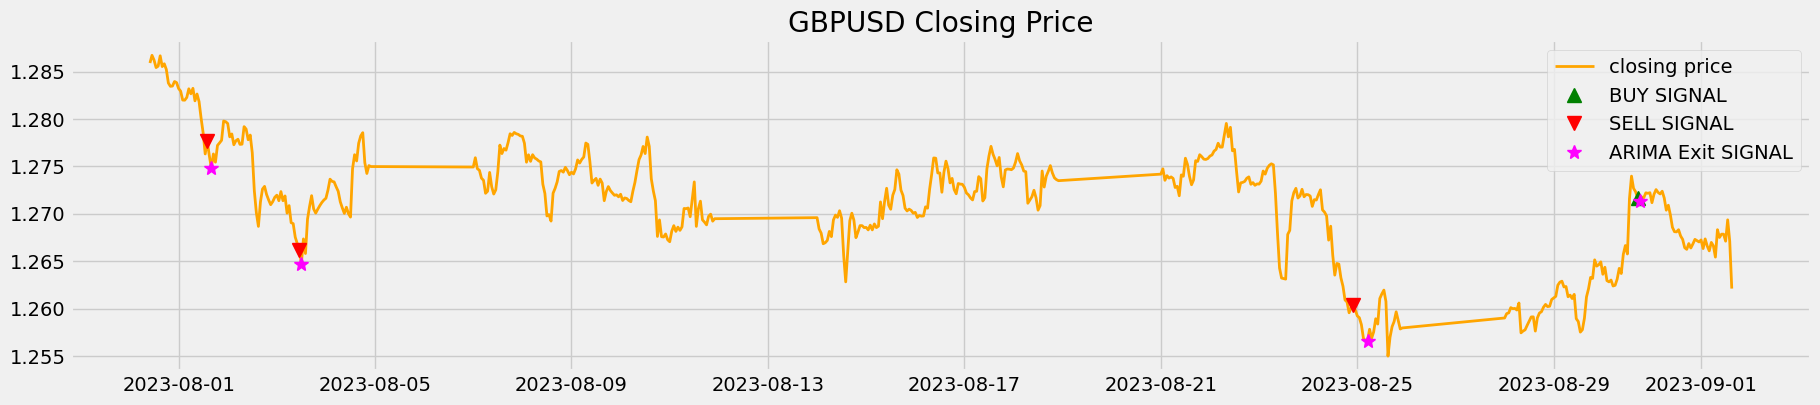

In [60]:
try:
    print('Plot showing trade entry (BUY & SELL) and ARIMA EXIT points on Optimised ADX Strategy')
    #initialize axes for closing balance and ADX repsectively
    ax1 = plt.subplot2grid((12,1), (0,0), rowspan = 5, colspan = 1)
    #ax2 = plt.subplot2grid((12,1), (6,0), rowspan = 5, colspan = 1)
    #Plot OHLC closing balance based on test data set
    ax1.plot(ohlc_test_data['close'], linewidth = 2, color = 'orange',label = 'closing price')
    ax1.set_title(f'{trading_pair} Closing Price')
    #plot trade entry points (buy & sell)
    ax1.plot(ohlc_test_data.index, buying_price, marker = '^', color = 'green', markersize = 10, linewidth = 0, label = 'BUY SIGNAL')
    ax1.plot(ohlc_test_data.index, selling_price, marker = 'v', color = 'red', markersize = 10, linewidth = 0, label = 'SELL SIGNAL')
    #Mark ADX exit signal
    #ax1.plot(ohlc_test_data.index, trade_exit_points, marker = 'o', color = 'blue', markersize = 10, linewidth = 0, label = 'ADX Exit SIGNAL')
    #Mark exit signal for ARIMA
    ax1.plot(ohlc_test_data.index, arima_exit_price_list, marker = '*', color = 'magenta', markersize = 10, linewidth = 0, label = 'ARIMA Exit SIGNAL')
    #plot Average Directional Movement Index (ADX) parameters
    #ax2.plot(ohlc_test_data['plus_di'], color = 'Green', label = '+ DI 14', linewidth = 2, alpha = 0.3)
    #ax2.plot(ohlc_test_data['minus_di'], color = 'blue', label = '- DI 14', linewidth = 2, alpha = 0.5)
    #ax2.plot(ohlc_test_data['adx'], color = 'Black', label = 'ADX 14', linewidth = 2)
    #ax2.axhline(adx_threshold, color = 'red', linewidth = 2, linestyle = '--',label='ADX Threshold')
    #append legends for both axes
    ax1.legend()
    #ax2.legend()
   # ax2.set_title(f'Average Directional Movement Index (ADX-14) for: {trading_pair}')
    #render the plots
    plt.show()
except Exception as err:
    print(err)

In [61]:
#backtesting optimized ADX strategy
bt = Backtest(ohlc_bt_data, optimized_adx_strategy, cash=100, margin=1/100, commission=.00)
stat = bt.run()
stat      

D:\projects\XY03222\venv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning:

divide by zero encountered in scalar divide



Start                     2023-07-31 10:00...
End                       2023-09-01 15:00...
Duration                     32 days 05:00:00
Exposure Time [%]                    1.903114
Equity Final [$]                    134.13556
Equity Peak [$]                     134.13556
Return [%]                           34.13556
Buy & Hold Return [%]               -1.850052
Return (Ann.) [%]                 1830.379876
Volatility (Ann.) [%]             1446.868863
Sharpe Ratio                         1.265063
Sortino Ratio                             inf
Calmar Ratio                     17599.685774
Max. Drawdown [%]                   -0.104001
Avg. Drawdown [%]                   -0.104001
Max. Drawdown Duration        0 days 02:00:00
Avg. Drawdown Duration        0 days 02:00:00
# Trades                                    2
Win Rate [%]                            100.0
Best Trade [%]                       0.336166
Worst Trade [%]                      0.296769
Avg. Trade [%]                    

<h3><strong><center>Section (vii): Trading Strategies (ii)</center></strong></h3>

<h4><strong><left>Divergence Trading Strategy (Unoptimized)</left></strong></h4>

In [62]:
#Adding necessary columns for the strategy
#create and populate RSI column on dataframe
ohlc_test_data['rsi']=rsi(ohlc_test_data,rsi_period)

Using Exponential Moving average
RSI calculated successfully


In [63]:
 #Add ATR (Average True Range)
ohlc_test_data = atr(ohlc_test_data,atr_window_size)

average true range (ATR) added successfully


In [64]:
#get maximas (peaks) and minimas(troughs)
ohlc_test_data,lower_low_indx,peaks_idx,troughs_idx,comb_list = get_div_maxima_minima(ohlc_test_data,peaks_distance,peaks_width)

Maxima and Minima generated successfully


<h4><strong><left>Market Entry using Divergence Strategy</left></strong></h4>

In [65]:
ohlc_test_data,div_cnt,entry_signal_index,div_entry_rows = generate_div_entry_signals(ohlc_test_data,lower_low_indx)
print(f'{div_cnt} diversion point(s) identified')

(30, 73)
2023-08-03 11:00:00+01:00
73
Divergence point identified
(116, 146)
(183, 203)
(305, 334)
(388, 407)
(407, 448)
2023-08-25 05:00:00+01:00
448
Divergence point identified
2 Divergence points selected successfully
2 diversion point(s) identified


<h4><strong><left>Market Exit using Divergence Strategy</left></strong></h4>

In [66]:
entry_exit_signals=[]
div_exit_rows = []

In [67]:
#use enumerate so as to get row position as an integer
for k in div_entry_rows:
    #loop through trade entry indices as well
    for idx,(i,j) in enumerate(ohlc_test_data.iterrows()):
        #if trade entry time is greater than current index and closing price has crossed EMA50 (downward); Exit the trade
        if (idx>k and j.EMA20>=j.EMA50 and ohlc_test_data.EMA20[idx-1]<ohlc_test_data.EMA50[idx]):
            #append the exit row position & the corresponding entry position
            print(k)
            #we will append both entry and exit to ensure that for every entry, there is a corresponding exit
            entry_exit_signals.append((k,idx))
            div_exit_rows.append(idx)
            break

73
448


In [68]:
print(div_entry_rows)
print(div_exit_rows)

[73, 448]
[103, 497]


In [69]:
##Append the adx unoptimised strategy entry signals(buy(2) and sell(1)) on the dataframe
#initialize buysell signals for adx strategy
ohlc_bt_data['div_buysell_signal'] = 0
#append div entry sell signals (1)
#ohlc_bt_data.iloc[selling_indices,[13]] = 1
#append buy signals (2)
ohlc_bt_data.iloc[div_entry_rows,[17]] = 2

#Append the adx unoptimised strategy exit signals on the dataframe
#initialize buysell signals for adx strategy
ohlc_bt_data['div_exit_signal'] = 0
#append exit signals (1)
ohlc_bt_data.iloc[div_exit_rows,[18]] = 1

#backtesting unoptimised ADX strategy
bt = Backtest(ohlc_bt_data, unoptimized_div_strategy, cash=100, margin=1/100, commission=.00)
stat = bt.run()
stat      

D:\projects\XY03222\venv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning:

divide by zero encountered in scalar divide



Start                     2023-07-31 10:00...
End                       2023-09-01 15:00...
Duration                     32 days 05:00:00
Exposure Time [%]                   14.013841
Equity Final [$]                    183.10304
Equity Peak [$]                     192.56889
Return [%]                           83.10304
Buy & Hold Return [%]               -1.850052
Return (Ann.) [%]                44360.177529
Volatility (Ann.) [%]            66813.989799
Sharpe Ratio                         0.663935
Sortino Ratio                             inf
Calmar Ratio                      1949.839218
Max. Drawdown [%]                  -22.750685
Avg. Drawdown [%]                   -6.513684
Max. Drawdown Duration        3 days 13:00:00
Avg. Drawdown Duration        0 days 22:00:00
# Trades                                    2
Win Rate [%]                            100.0
Best Trade [%]                       1.069709
Worst Trade [%]                      0.385993
Avg. Trade [%]                    

In [70]:
trades_summary = []
trade_type = 'B'
div_exit_cls_price =[]
trades_summary,div_exit_cls_price = divergence_strategy_exit(ohlc_test_data,trading_pair,trade_type,lot_size,entry_exit_signals)

In [71]:
trades_summary

[('GBPUSD',
  'B',
  0.5,
  '08-03-2023, 11:00:00',
  '08-04-2023, 17:00:00',
  1.26618,
  1.27822),
 ('GBPUSD',
  'B',
  0.5,
  '08-25-2023, 05:00:00',
  '08-29-2023, 07:00:00',
  1.25663,
  1.26126)]

In [72]:
#mark exits for Divergence using EMA50
div_exit_price_list = [np.nan for i in range(len(ohlc_test_data))]

In [73]:
idx = [i for i,j in div_exit_cls_price]
closing_prices = [j for i,j in div_exit_cls_price]
for b, c in zip(idx, closing_prices):
    setitem(div_exit_price_list, b, c)

a figure with (1) subplots initialized successfully
Plotting close_smooth successful
plotting low_highs successful
Plotting low to lower-lows successful
layout set successfully
y-axes labelled successfully
x-axes labelled successfully
Title labelled successfully
figure rendered successfully


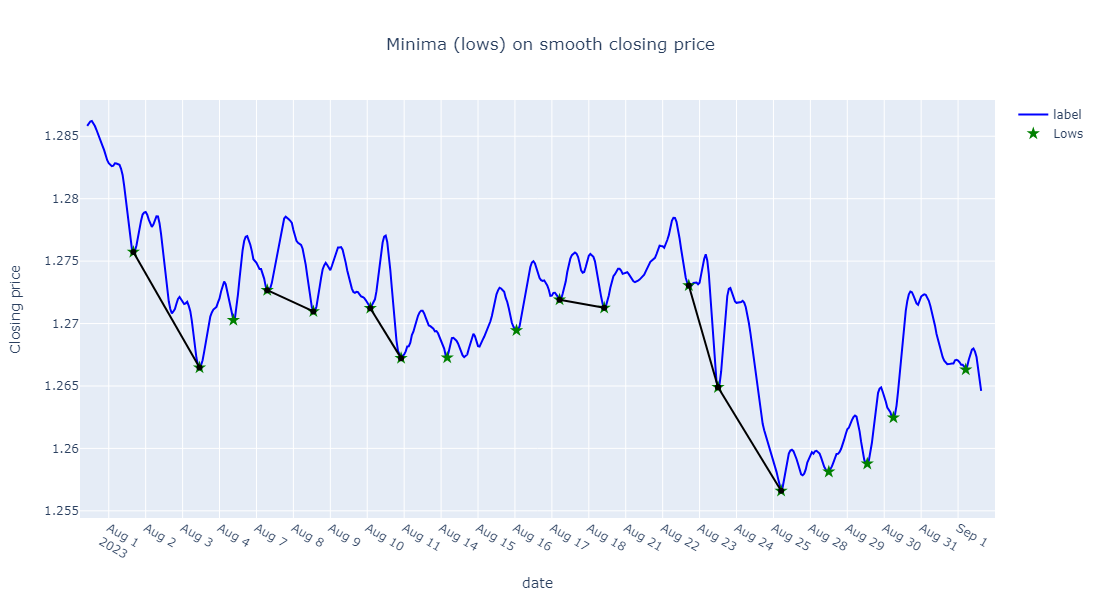

In [74]:
####################
#visualize the data
####################
fig = define_plotly_subplots(1,1,0.03,[0.3])
#plot_ohlc_data(fig,ohlc_test_data,1,1)
plot_df_column(fig,ohlc_test_data,'close_smooth',1,1,'blue','label')
#plot_smoothed_close(fig,ohlc_data,1,1,'blue','smoothed closing Price')
plot_lows_highs(fig,ohlc_test_data,peaks_idx,troughs_idx,1,1,'green')
plot_low_lower_lows(fig,ohlc_test_data,lower_low_indx,1,1,'black')
#plot_rsi(fig,ohlc_test_data,2,1,'orange')
#lower_low_on_rsi(fig,ohlc_test_data,lower_low_indx,2,1,'black')
fig_layout(fig,1000,600)
label_axes(fig,'date','Closing price','Minima (lows) on smooth closing price',1,1)
#label_axes(fig,'Date','RSI','',2,1)
#Remove some labels on the Legend
for trace in fig['data']:
    # hide some legend column names labeled as "trace 0"
    if trace['name'] ==None:trace['showlegend'] = False
show_figure(fig)

a figure with (2) subplots initialized successfully
Plotting close_smooth successful
plotting low_highs successful
Plotting low to lower-lows successful
Plotting RSI successful
plotting lower-lows against RSI was successful
layout set successfully
y-axes labelled successfully
x-axes labelled successfully
Title labelled successfully
y-axes labelled successfully
x-axes labelled successfully
Title labelled successfully
figure rendered successfully


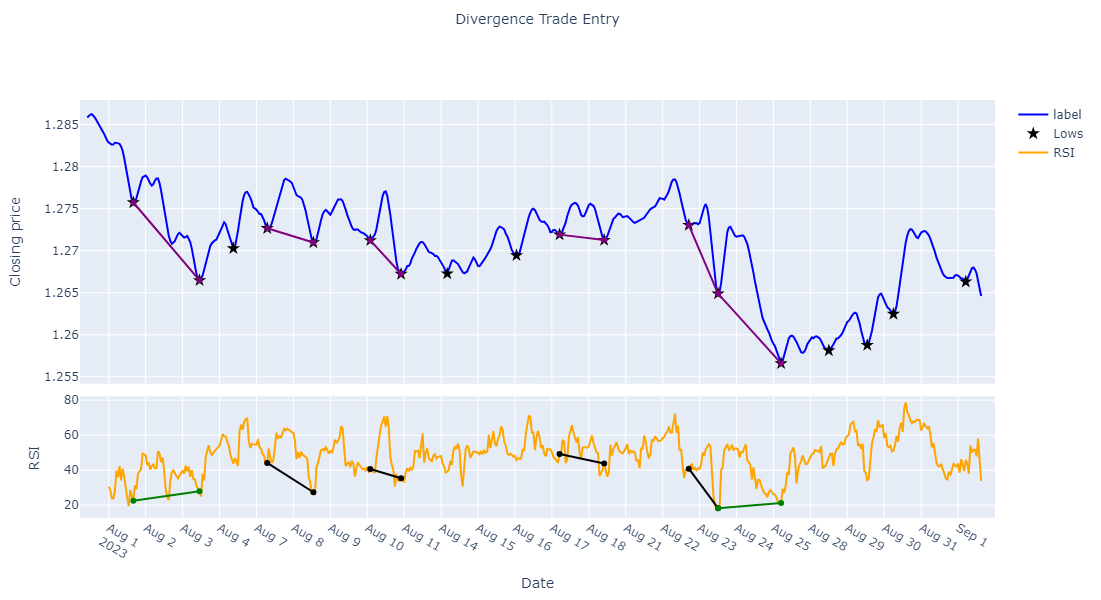

In [75]:
####################
#visualize the data
####################
fig = define_plotly_subplots(2,1,0.03,[0.3,0.7])
#plot_ohlc_data(fig,ohlc_test_data,1,1)
plot_df_column(fig,ohlc_test_data,'close_smooth',1,1,'blue','label')
#plot_smoothed_close(fig,ohlc_data,1,1,'blue','smoothed closing Price')
plot_lows_highs(fig,ohlc_test_data,peaks_idx,troughs_idx,1,1,'black')
plot_low_lower_lows(fig,ohlc_test_data,lower_low_indx,1,1,'purple')
plot_rsi(fig,ohlc_test_data,2,1,'orange')
lower_low_on_rsi(fig,ohlc_test_data,lower_low_indx,2,1,'black')
fig_layout(fig,900,600)
label_axes(fig,'Divergence Trade Entry','Closing price','',1,1)
label_axes(fig,'Date','RSI','',2,1)
#Remove some labels on the Legend
for trace in fig['data']:
    # hide some legend column names labeled as "trace 0"
    if trace['name'] ==None:trace['showlegend'] = False
show_figure(fig)

a figure with (2) subplots initialized successfully
Plotting close_smooth successful
plotting low_highs successful
Plotting low to lower-lows successful
Plotting RSI successful
plotting lower-lows against RSI was successful
Plotting EMA50 successful
Plotting EMA20 successful
layout set successfully
y-axes labelled successfully
x-axes labelled successfully
Title labelled successfully
y-axes labelled successfully
x-axes labelled successfully
Title labelled successfully
figure rendered successfully


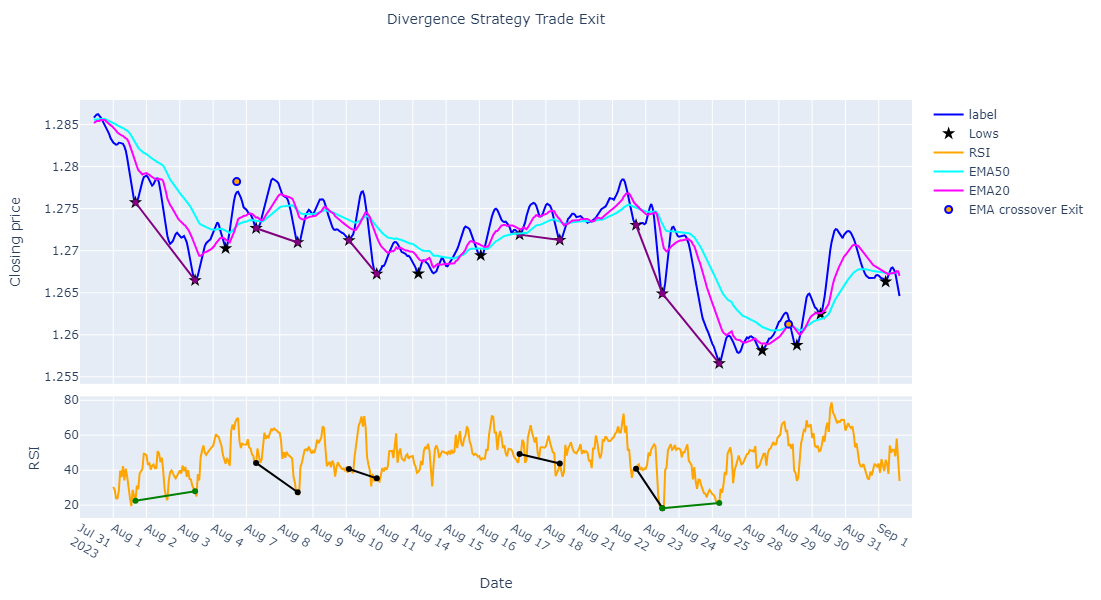

In [76]:
####################
#visualize the data
####################
fig = define_plotly_subplots(2,1,0.03,[0.3,0.7])
#plot_ohlc_data(fig,ohlc_test_data,1,1)
plot_df_column(fig,ohlc_test_data,'close_smooth',1,1,'blue','label')
#plot_smoothed_close(fig,ohlc_data,1,1,'blue','smoothed closing Price')
plot_lows_highs(fig,ohlc_test_data,peaks_idx,troughs_idx,1,1,'black')
plot_low_lower_lows(fig,ohlc_test_data,lower_low_indx,1,1,'purple')
plot_rsi(fig,ohlc_test_data,2,1,'orange')
lower_low_on_rsi(fig,ohlc_test_data,lower_low_indx,2,1,'black')
plot_df_column(fig,ohlc_test_data,'EMA50',1,1,'cyan','EMA50')
plot_df_column(fig,ohlc_test_data,'EMA20',1,1,'magenta','EMA20')
#Marking exit signal for divergence on EMA50
fig.add_trace(
    go.Scatter(
        mode='markers',
        x=ohlc_test_data.index,
        y=div_exit_price_list,
        marker=dict(
            color='orange',
            size=7,
            line=dict(
                color='blue',
                width=2
            )
        ),
        name='EMA crossover Exit'
    )
)
fig_layout(fig,1000,600)
label_axes(fig,'Divergence Strategy Trade Exit','Closing price','',1,1)
label_axes(fig,'Date','RSI','',2,1)
#Remove some labels on the Legend
for trace in fig['data']:
    # hide some legend column names labeled as "trace 0"
    if trace['name'] ==None:trace['showlegend'] = False
show_figure(fig)

<h3><strong><center>Section (viii): Optimizing Divergence Trading strategy</center></strong></h3>

<h4><strong><left>Generate optimized Divergence trade exit based on ARIMA Model predictions</left></strong></h4>

In [77]:
trades_summary=[]
trade_type = 'B'
arima_exit_price = []
div_ar_entry_rows = []
div_ar_exit_rows = []
trades_summary,div_ar_entry_rows,div_ar_exit_rows = generate_arima_summary(trading_pair,trade_type,lot_size,ohlc_test_data_ar,entry_exit_signals)

(83, 1.2712204272371936, 0)
(454, 1.2598043296776948, -1)


In [78]:
trades_summary

[('GBPUSD',
  'B',
  0.5,
  '08-03-2023, 11:00:00',
  '08-03-2023, 21:00:00',
  1.26647,
  1.271),
 ('GBPUSD',
  'B',
  0.5,
  '08-25-2023, 06:00:00',
  '08-25-2023, 12:00:00',
  1.2569,
  1.26)]

In [79]:
arima_exit_price_list = [np.nan for i in range(len(ohlc_test_data))]

In [80]:
idx = [i for i,j in arima_exit_price]
closing_prices = [j for i,j in arima_exit_price]
for b, c in zip(idx, closing_prices):
    setitem(arima_exit_price_list, b, c)

a figure with (2) subplots initialized successfully
Plotting close_smooth successful
plotting low_highs successful
Plotting low to lower-lows successful
Plotting RSI successful
plotting lower-lows against RSI was successful
layout set successfully
y-axes labelled successfully
x-axes labelled successfully
Title labelled successfully
y-axes labelled successfully
x-axes labelled successfully
Title labelled successfully
figure rendered successfully


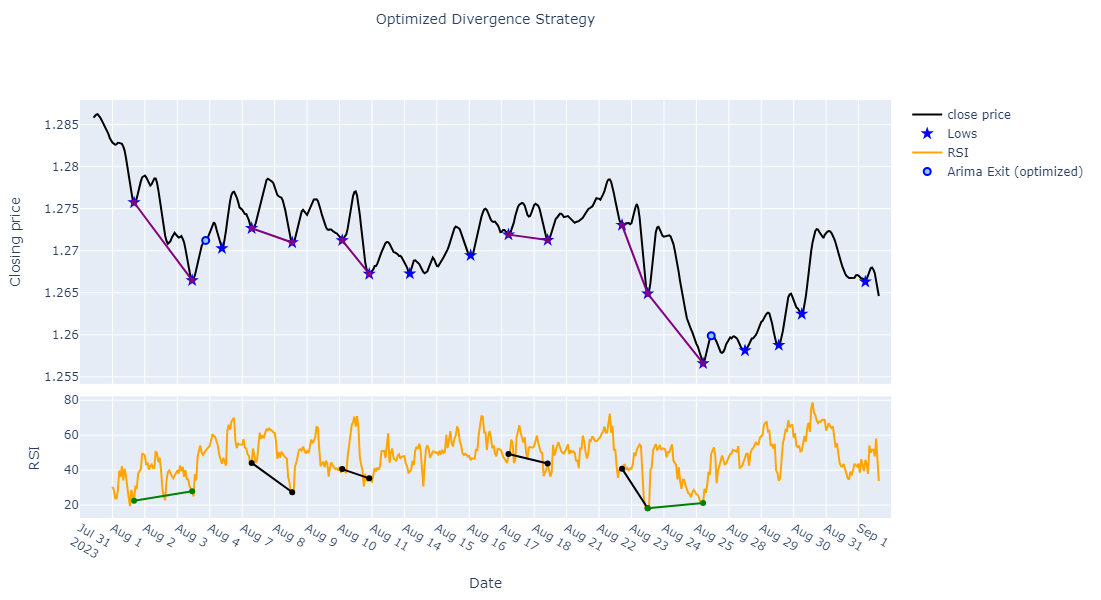

In [81]:
####################
#visualize the data
####################
fig = define_plotly_subplots(2,1,0.03,[0.3,0.7])
#plot_ohlc_data(fig,ohlc_test_data,1,1)
plot_df_column(fig,ohlc_test_data,'close_smooth',1,1,'black','close price')
#plot_smoothed_close(fig,ohlc_data,1,1,'blue','smoothed closing Price')
plot_lows_highs(fig,ohlc_test_data,peaks_idx,troughs_idx,1,1,'blue')
plot_low_lower_lows(fig,ohlc_test_data,lower_low_indx,1,1,'purple')
plot_rsi(fig,ohlc_test_data,2,1,'orange')
lower_low_on_rsi(fig,ohlc_test_data,lower_low_indx,2,1,'black')
#Marking exit signal for ARIMA
fig.add_trace(
    go.Scatter(
        mode='markers',
        x=ohlc_test_data.index,
        y=arima_exit_price_list,
        marker=dict(
            color='LightSkyBlue',
            size=7,
            line=dict(
                color='blue',
                width=2
            )
        ),
        name='Arima Exit (optimized)'
    )
)
fig_layout(fig,1000,600)
label_axes(fig,'Optimized Divergence Strategy','Closing price','',1,1)
label_axes(fig,'Date','RSI','',2,1)
#Remove some labels on the Legend
for trace in fig['data']:
    # hide some legend column names labeled as "trace 0"
    if trace['name'] ==None:trace['showlegend'] = False
show_figure(fig)

In [82]:
print(div_ar_entry_rows)
print(div_ar_exit_rows)

[73, 448]
[83, 454]


In [83]:
##Append the adx unoptimised strategy entry signals(buy(2) and sell(1)) on the dataframe
#initialize buysell signals for adx strategy
ohlc_bt_data['div_ar_buysell_signal'] = 0
#append div entry sell signals (1)
#ohlc_bt_data.iloc[selling_indices,[13]] = 1
#append buy signals (2)
ohlc_bt_data.iloc[div_ar_entry_rows,[19]] = 2

#Append the adx unoptimised strategy exit signals on the dataframe
#initialize buysell signals for adx strategy
ohlc_bt_data['div_ar_exit_signal'] = 0
#append exit signals (1)
ohlc_bt_data.iloc[div_ar_exit_rows,[20]] = 1

#backtesting optimised divergence strategy
bt = Backtest(ohlc_bt_data, optimized_div_strategy, cash=100, margin=1/100, commission=.00)
stat = bt.run()
stat      

D:\projects\XY03222\venv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning:

divide by zero encountered in scalar divide



Start                     2023-07-31 10:00...
End                       2023-09-01 15:00...
Duration                     32 days 05:00:00
Exposure Time [%]                    3.114187
Equity Final [$]                    151.46166
Equity Peak [$]                     151.46166
Return [%]                           51.46166
Buy & Hold Return [%]               -1.850052
Return (Ann.) [%]                 6468.275193
Volatility (Ann.) [%]             9078.617252
Sharpe Ratio                         0.712474
Sortino Ratio                             inf
Calmar Ratio                      1138.530423
Max. Drawdown [%]                   -5.681249
Avg. Drawdown [%]                   -3.430608
Max. Drawdown Duration       21 days 13:00:00
Avg. Drawdown Duration        4 days 10:00:00
# Trades                                    2
Win Rate [%]                            100.0
Best Trade [%]                       0.539203
Worst Trade [%]                      0.385993
Avg. Trade [%]                    

In [84]:
                                                      ##########################END########################